# §106. English Qatal Translation Overview

The dataset is as many qatal verbs that:

* do not have a prepended waw
* we have a successful link between the Hebrew word and the translation
* the parse is not erroneous or spurious (filtered out bad cases)
    
In this NB, "pr" refers to proportions taken across rows (percentages when multiplied by 100).

"oneN" refers to odds, read as "one in N"

Various tags are used to refer to English Tense, Aspect, Modality constructions (TAM).

In [2]:
import sys
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# NB imports to follow from /tools
sys.path.append('../tools/')
from load_dfs import qatal_df, qatal_dfs
from analysis import * # see file for variables
from df_styles import TextShower
from plotting import plot_bar_1D, heatmap

ModuleNotFoundError: No module named 'load_dfs'

In [2]:
pd.set_option('display.max_columns', 0)

In [3]:
# set up code and variables, see my_tools.py for unseen vars
ts = TextShower(
    default=['ref', 'text_full', 'sentence', 
             'esv_TAMspan', 'esv_TAM', 
             'niv_TAMspan', 'niv_TAM']
)

ts_tr = TextShower(
    default=['ref', 'text_full', 'sentence', 
             'esv_TAMspan', 'esv_TAM', 'esv_verse',
             'niv_TAMspan', 'niv_TAM', 'niv_verse']
)

main_genre = ['prose', 'poetry', 'prophetic']
main_dom = ['Q', 'N']

In [4]:
qatal_dfs.columns

Index(['ref', 'book', 'book_super', 'canon_part', 'text_full', 'text_plain',
       'lex', 'lex_etcbc', 'gloss', 'verb_form', 'stem', 'person', 'gender',
       'number', 'clause_atom', 'clause', 'sentence', 'genre', 'domain',
       'domain2', 'period', 'txt_type', 'clause_type', 'cltype_simp',
       'clause_rela', 'mother_clause', 'mother_type', 'mother_verbtype',
       'mother_rela', 'mother_domain2', 'daught_clause', 'daught_type',
       'daught_verbtype', 'daught_rela', 'daught_domain2', 'valence',
       'prec_lexes', 'prec_pos', 'prec_part', 'lxx', 'lxx_tense', 'lxx_voice',
       'lxx_mood', 'lxx_person', 'lxx_number', 'lxx_tm', 'esv', 'esv_tags',
       'esv_VBtags', 'esv_verse', 'esv_tense', 'esv_aspect', 'esv_modality',
       'esv_TAM', 'esv_TAMtag', 'esv_TAMspan', 'niv', 'niv_tags', 'niv_VBtags',
       'niv_verse', 'niv_tense', 'niv_aspect', 'niv_modality', 'niv_TAM',
       'niv_TAMtag', 'niv_TAMspan', 'safe'],
      dtype='object')

In [1]:
qatal_dfs

NameError: name 'qatal_dfs' is not defined

## Rough sense of TAM tag quantities

In [5]:
qatal_dfs.esv_TAM.value_counts()

PAST..IND             5203
PRES.PERF.IND         3432
PRES..IND             2632
PAST.PERF.IND         1420
PRES..IMPV             240
PRES..MOD              138
PAST..SUBJ              97
FUT..IND                90
PRES..                  76
PAST.PROG.IND           28
PRES.PROG.IND           20
..                      14
PRES.PERF_PROG.IND       5
FUT.PERF.IND             4
past.PERF_PROG.IND       2
Name: esv_TAM, dtype: int64

In [6]:
qatal_dfs.niv_TAM.value_counts()

PAST..IND             4994
PRES.PERF.IND         2753
PRES..IND             2662
PAST.PERF.IND         1472
FUT..IND               352
PRES..IMPV             244
PRES..                 145
PRES..MOD              115
PAST..SUBJ              91
PRES.PROG.IND           74
..                      54
PAST.PROG.IND           49
past.PERF_PROG.IND       9
PRES.PERF_PROG.IND       8
FUT..MOD                 3
FUT.PERF.IND             3
Name: niv_TAM, dtype: int64

Some of these are either very rare or spurious (e.g. PRES..IMPV [imperative]; caused by 
shortcomings in the English parser)

## Setup Translation Data

Filter out spurious or rare data.

In [7]:
# based on above counts, we want to
# for the moment exclude idiosyncratic translations
# especially translations that might actually be 
# bad parses

main_tenses = '''
PAST..IND
PRES.PERF.IND
PRES..IND
PAST.PERF.IND
'''.strip().split('\n')

exclude = [
    'PRES..IMPV'
]

# remove cases of 'did not' for now since these are semantically ambiguous
qatal_dfs2 = qatal_dfs[
    (~qatal_dfs.esv_TAMspan.str.match('.*did not.*', na=False))
    & (~qatal_dfs.niv_TAMspan.str.match('.*did not.*', na=False))
]

# make a set of dfs with respective data and prerequisites
esv_df = qatal_dfs2[(~qatal_dfs2.esv_TAM.isin(exclude)) & (qatal_dfs2.esv_TAM)]
niv_df = qatal_dfs2[(~qatal_dfs2.niv_TAM.isin(exclude)) & (qatal_dfs2.niv_TAM)]
eng_df = qatal_dfs2.loc[list(set(esv_df.index) & set(niv_df.index))] # both parses are in main semantics
eng_df.sort_values(by='bhsa_node', inplace=True)

# add a column for counting agreement/disagreement by translation
eng_df['disagree'] = 1*(eng_df.esv_TAM != eng_df.niv_TAM)
engag_df = eng_df[eng_df.disagree == 0] # English agreement df

In [8]:
esv_df.shape # i.e. dimensions of the new tables

(12679, 67)

In [9]:
niv_df.shape

(12309, 67)

In [10]:
eng_df.shape

(11907, 68)

In [11]:
ag_ct = eng_df['disagree'].value_counts()

ag_ct

0    9573
1    2334
Name: disagree, dtype: int64

In [12]:
ag_ct[0] / ag_ct.sum()

0.8039808515998992

## General Counts by Translation

In [13]:
esv_tam_ct = eng_df.esv_TAM.value_counts()
esv_tam_pr = prop_table(esv_tam_ct)
niv_tam_ct = eng_df.niv_TAM.value_counts()
niv_tam_pr = prop_table(niv_tam_ct)

### ESV

In [14]:
esv_tam_ct

PAST..IND             4830
PRES.PERF.IND         3264
PRES..IND             2434
PAST.PERF.IND          943
PRES..MOD              128
PAST..SUBJ              92
FUT..IND                84
PRES..                  66
PAST.PROG.IND           24
PRES.PROG.IND           20
..                      13
FUT.PERF.IND             4
PRES.PERF_PROG.IND       3
past.PERF_PROG.IND       2
Name: esv_TAM, dtype: int64

In [15]:
esv_tam_pr

PAST..IND             0.405644
PRES.PERF.IND         0.274124
PRES..IND             0.204418
PAST.PERF.IND         0.079197
PRES..MOD             0.010750
PAST..SUBJ            0.007727
FUT..IND              0.007055
PRES..                0.005543
PAST.PROG.IND         0.002016
PRES.PROG.IND         0.001680
..                    0.001092
FUT.PERF.IND          0.000336
PRES.PERF_PROG.IND    0.000252
past.PERF_PROG.IND    0.000168
Name: esv_TAM, dtype: float64

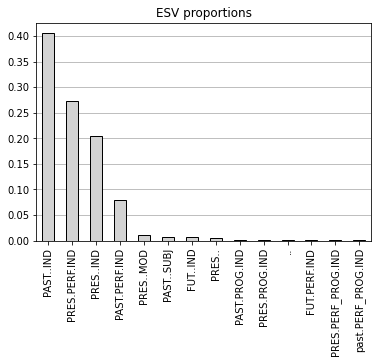

In [16]:
plot_bar_1D(esv_tam_pr, title='ESV proportions')

### NIV

In [17]:
niv_tam_ct

PAST..IND             4795
PRES.PERF.IND         2686
PRES..IND             2506
PAST.PERF.IND         1101
FUT..IND               333
PRES..                 130
PRES..MOD              102
PAST..SUBJ              73
PRES.PROG.IND           69
PAST.PROG.IND           47
..                      46
past.PERF_PROG.IND       8
PRES.PERF_PROG.IND       5
FUT..MOD                 3
FUT.PERF.IND             3
Name: niv_TAM, dtype: int64

In [18]:
niv_tam_pr

PAST..IND             0.402704
PRES.PERF.IND         0.225582
PRES..IND             0.210464
PAST.PERF.IND         0.092467
FUT..IND              0.027967
PRES..                0.010918
PRES..MOD             0.008566
PAST..SUBJ            0.006131
PRES.PROG.IND         0.005795
PAST.PROG.IND         0.003947
..                    0.003863
past.PERF_PROG.IND    0.000672
PRES.PERF_PROG.IND    0.000420
FUT..MOD              0.000252
FUT.PERF.IND          0.000252
Name: niv_TAM, dtype: float64

In [90]:
# compare with ESV
(niv_tam_pr - esv_tam_pr).sort_values(ascending=False)

FUT..IND              0.020912
PAST.PERF.IND         0.013270
PRES..IND             0.006047
PRES..                0.005375
PRES.PROG.IND         0.004115
..                    0.002771
PAST.PROG.IND         0.001932
past.PERF_PROG.IND    0.000504
PRES.PERF_PROG.IND    0.000168
FUT.PERF.IND         -0.000084
PAST..SUBJ           -0.001596
PRES..MOD            -0.002184
PAST..IND            -0.002939
PRES.PERF.IND        -0.048543
FUT..MOD                   NaN
dtype: float64

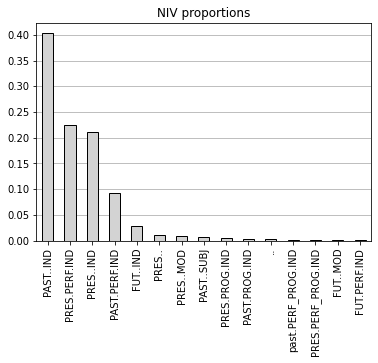

In [20]:
plot_bar_1D(niv_tam_pr, title='NIV proportions')

### ESV & NIV (agreement)

In [21]:
eng_tam_ct = eng_df[eng_df.disagree == 0].esv_TAM.value_counts()
eng_tam_pr = prop_table(eng_tam_ct)

eng_tam_ct

PAST..IND             4116
PRES.PERF.IND         2354
PRES..IND             2062
PAST.PERF.IND          782
FUT..IND                69
PAST..SUBJ              62
PRES..MOD               55
PRES..                  32
PRES.PROG.IND           18
PAST.PROG.IND           13
..                       5
past.PERF_PROG.IND       2
FUT.PERF.IND             2
PRES.PERF_PROG.IND       1
Name: esv_TAM, dtype: int64

In [22]:
eng_tam_pr

PAST..IND             0.429959
PRES.PERF.IND         0.245900
PRES..IND             0.215397
PAST.PERF.IND         0.081688
FUT..IND              0.007208
PAST..SUBJ            0.006477
PRES..MOD             0.005745
PRES..                0.003343
PRES.PROG.IND         0.001880
PAST.PROG.IND         0.001358
..                    0.000522
past.PERF_PROG.IND    0.000209
FUT.PERF.IND          0.000209
PRES.PERF_PROG.IND    0.000104
Name: esv_TAM, dtype: float64

In [23]:
eng_tam_pr[main_tenses]

PAST..IND        0.429959
PRES.PERF.IND    0.245900
PRES..IND        0.215397
PAST.PERF.IND    0.081688
Name: esv_TAM, dtype: float64

In [24]:
eng_tam_pr[main_tenses].sum()

0.9729447404157526

In [25]:
eng_tam_pr[~eng_tam_pr.index.isin(main_tenses)].sum()

0.027055259584247364

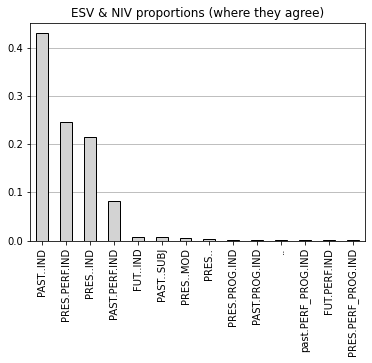

In [26]:
plot_bar_1D(eng_tam_pr, title='ESV & NIV proportions (where they agree)')

In [27]:
# # get and show a spread of contexts
# for tam_tag in eng_tam_pr.index:
#     display(HTML(f'<h4>{tam_tag}</h4>'))
#     display(ts_tr.show(engag_df[engag_df.esv_TAM == tam_tag], spread=10))

### ESV & NIV Mean

In [28]:
both_tam_pr = pd.concat([esv_tam_pr, niv_tam_pr], axis=1)

both_tam_pr

,esv_TAM,niv_TAM
PAST..IND,0.405644,0.402704
PRES.PERF.IND,0.274124,0.225582
PRES..IND,0.204418,0.210464
PAST.PERF.IND,0.079197,0.092467
PRES..MOD,0.010750,0.008566
PAST..SUBJ,0.007727,0.006131
FUT..IND,0.007055,0.027967
PRES..,0.005543,0.010918
PAST.PROG.IND,0.002016,0.003947
PRES.PROG.IND,0.001680,0.005795


In [29]:
# now take the mean and std

In [30]:
btp_mean = both_tam_pr.mean(1)

btp_mean

PAST..IND             0.404174
PRES.PERF.IND         0.249853
PRES..IND             0.207441
PAST.PERF.IND         0.085832
PRES..MOD             0.009658
PAST..SUBJ            0.006929
FUT..IND              0.017511
PRES..                0.008230
PAST.PROG.IND         0.002981
PRES.PROG.IND         0.003737
..                    0.002478
FUT.PERF.IND          0.000294
PRES.PERF_PROG.IND    0.000336
past.PERF_PROG.IND    0.000420
FUT..MOD              0.000252
dtype: float64

In [31]:
btp_mean[main_tenses]

PAST..IND        0.404174
PRES.PERF.IND    0.249853
PRES..IND        0.207441
PAST.PERF.IND    0.085832
dtype: float64

In [32]:
btp_mean[~btp_mean.index.isin(main_tenses)].sum()

0.05282606869908457

In [33]:
both_tam_pr.std(1)

PAST..IND             0.002079
PRES.PERF.IND         0.034325
PRES..IND             0.004276
PAST.PERF.IND         0.009383
PRES..MOD             0.001544
PAST..SUBJ            0.001128
FUT..IND              0.014787
PRES..                0.003801
PAST.PROG.IND         0.001366
PRES.PROG.IND         0.002910
..                    0.001960
FUT.PERF.IND          0.000059
PRES.PERF_PROG.IND    0.000119
past.PERF_PROG.IND    0.000356
FUT..MOD                   NaN
dtype: float64

## Translation Diagreements (unidirectional)

### Run unidirectional

In [34]:
disag_df = eng_df[eng_df.esv_TAM != eng_df.niv_TAM]

disags = Analyze(disag_df, index='esv_TAM', columns='niv_TAM', fishers=False)

disags.show()

counts:


niv_TAM,PAST..IND,PRES..IND,PRES.PERF.IND,PAST.PERF.IND,FUT..IND,PRES..,PRES.PROG.IND,PRES..MOD,..,PAST.PROG.IND,PAST..SUBJ,past.PERF_PROG.IND,PRES.PERF_PROG.IND,FUT..MOD,FUT.PERF.IND
esv_TAM,,,,,,,,,,,,,,,
PRES.PERF.IND,410,293,0,38,95,22,25,9,8,4,0,0,4,1,1
PAST..IND,0,130,180,275,9,51,5,17,17,24,5,1,0,0,0
PRES..IND,77,0,127,2,109,13,19,16,7,1,1,0,0,0,0
PAST.PERF.IND,134,1,10,0,0,2,0,1,3,4,2,4,0,0,0
PRES..MOD,8,7,3,2,47,2,0,0,2,0,2,0,0,0,0
PRES..,22,3,6,0,0,0,1,1,0,1,0,0,0,0,0
PAST..SUBJ,19,0,4,0,1,1,0,2,3,0,0,0,0,0,0
FUT..IND,1,7,0,0,0,3,0,1,1,0,0,0,0,2,0
PAST.PROG.IND,6,0,0,2,0,2,0,0,0,0,0,1,0,0,0



proportions 1:


niv_TAM,PAST..IND,PRES..IND,PRES.PERF.IND,PAST.PERF.IND,FUT..IND,PRES..,PRES.PROG.IND,PRES..MOD,..,PAST.PROG.IND,PAST..SUBJ,past.PERF_PROG.IND,PRES.PERF_PROG.IND,FUT..MOD,FUT.PERF.IND
esv_TAM,,,,,,,,,,,,,,,
PRES.PERF.IND,0.450549,0.321978,0.000000,0.041758,0.104396,0.024176,0.027473,0.009890,0.008791,0.004396,0.000000,0.000000,0.004396,0.001099,0.001099
PAST..IND,0.000000,0.182073,0.252101,0.385154,0.012605,0.071429,0.007003,0.023810,0.023810,0.033613,0.007003,0.001401,0.000000,0.000000,0.000000
PRES..IND,0.206989,0.000000,0.341398,0.005376,0.293011,0.034946,0.051075,0.043011,0.018817,0.002688,0.002688,0.000000,0.000000,0.000000,0.000000
PAST.PERF.IND,0.832298,0.006211,0.062112,0.000000,0.000000,0.012422,0.000000,0.006211,0.018634,0.024845,0.012422,0.024845,0.000000,0.000000,0.000000
PRES..MOD,0.109589,0.095890,0.041096,0.027397,0.643836,0.027397,0.000000,0.000000,0.027397,0.000000,0.027397,0.000000,0.000000,0.000000,0.000000
PRES..,0.647059,0.088235,0.176471,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000
PAST..SUBJ,0.633333,0.000000,0.133333,0.000000,0.033333,0.033333,0.000000,0.066667,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FUT..IND,0.066667,0.466667,0.000000,0.000000,0.000000,0.200000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000
PAST.PROG.IND,0.545455,0.000000,0.000000,0.181818,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000



proportions 2:


esv_TAM,PRES.PERF.IND,PAST..IND,PRES..IND,PAST.PERF.IND,PRES..MOD,PRES..,PAST..SUBJ,FUT..IND,PAST.PROG.IND,..,PRES.PROG.IND,PRES.PERF_PROG.IND,FUT.PERF.IND
niv_TAM,,,,,,,,,,,,,
PAST..IND,0.603829,0.000000,0.113402,0.197349,0.011782,0.032401,0.027982,0.001473,0.008837,0.002946,0.000000,0.000000,0.000000
PRES..IND,0.659910,0.292793,0.000000,0.002252,0.015766,0.006757,0.000000,0.015766,0.000000,0.004505,0.002252,0.000000,0.000000
PRES.PERF.IND,0.000000,0.542169,0.382530,0.030120,0.009036,0.018072,0.012048,0.000000,0.000000,0.003012,0.000000,0.003012,0.000000
PAST.PERF.IND,0.119122,0.862069,0.006270,0.000000,0.006270,0.000000,0.000000,0.000000,0.006270,0.000000,0.000000,0.000000,0.000000
FUT..IND,0.359848,0.034091,0.412879,0.000000,0.178030,0.000000,0.003788,0.000000,0.000000,0.000000,0.003788,0.000000,0.007576
PRES..,0.224490,0.520408,0.132653,0.020408,0.020408,0.000000,0.010204,0.030612,0.020408,0.020408,0.000000,0.000000,0.000000
PRES.PROG.IND,0.490196,0.098039,0.372549,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000
PRES..MOD,0.191489,0.361702,0.340426,0.021277,0.000000,0.021277,0.042553,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000
..,0.195122,0.414634,0.170732,0.073171,0.048780,0.000000,0.073171,0.024390,0.000000,0.000000,0.000000,0.000000,0.000000


As a proportion of all disagreements rather than across rows.

In [35]:
disags_pr3 = disags.ct / disags.ct.sum().sum()

disags_pr3

niv_TAM,PAST..IND,PRES..IND,PRES.PERF.IND,PAST.PERF.IND,FUT..IND,PRES..,PRES.PROG.IND,PRES..MOD,..,PAST.PROG.IND,PAST..SUBJ,past.PERF_PROG.IND,PRES.PERF_PROG.IND,FUT..MOD,FUT.PERF.IND
esv_TAM,,,,,,,,,,,,,,,
PRES.PERF.IND,0.175664,0.125536,0.000000,0.016281,0.040703,0.009426,0.010711,0.003856,0.003428,0.001714,0.000000,0.000000,0.001714,0.000428,0.000428
PAST..IND,0.000000,0.055698,0.077121,0.117823,0.003856,0.021851,0.002142,0.007284,0.007284,0.010283,0.002142,0.000428,0.000000,0.000000,0.000000
PRES..IND,0.032991,0.000000,0.054413,0.000857,0.046701,0.005570,0.008141,0.006855,0.002999,0.000428,0.000428,0.000000,0.000000,0.000000,0.000000
PAST.PERF.IND,0.057412,0.000428,0.004284,0.000000,0.000000,0.000857,0.000000,0.000428,0.001285,0.001714,0.000857,0.001714,0.000000,0.000000,0.000000
PRES..MOD,0.003428,0.002999,0.001285,0.000857,0.020137,0.000857,0.000000,0.000000,0.000857,0.000000,0.000857,0.000000,0.000000,0.000000,0.000000
PRES..,0.009426,0.001285,0.002571,0.000000,0.000000,0.000000,0.000428,0.000428,0.000000,0.000428,0.000000,0.000000,0.000000,0.000000,0.000000
PAST..SUBJ,0.008141,0.000000,0.001714,0.000000,0.000428,0.000428,0.000000,0.000857,0.001285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FUT..IND,0.000428,0.002999,0.000000,0.000000,0.000000,0.001285,0.000000,0.000428,0.000428,0.000000,0.000000,0.000000,0.000000,0.000857,0.000000
PAST.PROG.IND,0.002571,0.000000,0.000000,0.000857,0.000000,0.000857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000428,0.000000,0.000000,0.000000


## Translation Disagreements (unidirectional)

Rather than tracking which TAM belong to which translation, we want to count
by simple TAM interchanges between the two translations. We do that below.

In [157]:
combined_disag = (disag_df.esv_TAM + ' ' + disag_df.niv_TAM)

# do a bit of re-arranging of the strings so that we can
# ignore whether ESV/NIV has x or y and pay attention to 
# simple interchanges between TAM x and TAM y
interchanges = []
main_tenses2 = set(main_tenses)

for interchange in combined_disag:
    new_is = sorted(interchange.split()) # strings remapped alphabetically
    new_i = '{} ~ {}'.format(*new_is)
    if set(new_is).issubset(main_tenses2): # add marker to pick out main tense combos
        new_i = '*' + new_i
    interchanges.append(new_i)

# convert back to series and build counts
interchanges = pd.Series(interchanges, index=combined_disag.index)
inter_ct = interchanges.value_counts()
inter_pr = prop_table(inter_ct)
inter_oneN = 1 / inter_pr

# add a TAM interchange column to the eng_df
eng_df['TAM_inter'] = interchanges

inter_ct

*PAST..IND ~ PRES.PERF.IND            590
*PRES..IND ~ PRES.PERF.IND            420
*PAST..IND ~ PAST.PERF.IND            409
*PAST..IND ~ PRES..IND                207
FUT..IND ~ PRES..IND                  116
FUT..IND ~ PRES.PERF.IND               95
PAST..IND ~ PRES..                     73
*PAST.PERF.IND ~ PRES.PERF.IND         48
FUT..IND ~ PRES..MOD                   48
PAST..IND ~ PAST.PROG.IND              30
PRES.. ~ PRES.PERF.IND                 28
PRES.PERF.IND ~ PRES.PROG.IND          25
PAST..IND ~ PRES..MOD                  25
PAST..IND ~ PAST..SUBJ                 24
PRES..IND ~ PRES..MOD                  23
PRES..IND ~ PRES.PROG.IND              20
.. ~ PAST..IND                         19
PRES.. ~ PRES..IND                     16
PRES..MOD ~ PRES.PERF.IND              12
FUT..IND ~ PAST..IND                   10
.. ~ PRES.PERF.IND                      9
.. ~ PRES..IND                          9
PAST.PERF.IND ~ PAST.PROG.IND           6
PRES.PERF.IND ~ PRES.PERF_PROG.IND

In [158]:
inter_pr

*PAST..IND ~ PRES.PERF.IND            0.252785
*PRES..IND ~ PRES.PERF.IND            0.179949
*PAST..IND ~ PAST.PERF.IND            0.175236
*PAST..IND ~ PRES..IND                0.088689
FUT..IND ~ PRES..IND                  0.049700
FUT..IND ~ PRES.PERF.IND              0.040703
PAST..IND ~ PRES..                    0.031277
*PAST.PERF.IND ~ PRES.PERF.IND        0.020566
FUT..IND ~ PRES..MOD                  0.020566
PAST..IND ~ PAST.PROG.IND             0.012853
PRES.. ~ PRES.PERF.IND                0.011997
PRES.PERF.IND ~ PRES.PROG.IND         0.010711
PAST..IND ~ PRES..MOD                 0.010711
PAST..IND ~ PAST..SUBJ                0.010283
PRES..IND ~ PRES..MOD                 0.009854
PRES..IND ~ PRES.PROG.IND             0.008569
.. ~ PAST..IND                        0.008141
PRES.. ~ PRES..IND                    0.006855
PRES..MOD ~ PRES.PERF.IND             0.005141
FUT..IND ~ PAST..IND                  0.004284
.. ~ PRES.PERF.IND                    0.003856
.. ~ PRES..IN

In [159]:
# sum of props for major tenses
inter_pr[inter_pr.index.str.match('\*')].sum()

0.7185089974293059

In [160]:
# sum of props for minor tenses

inter_pr[~inter_pr.index.str.match('\*')].sum()

0.28149100257069404

In [161]:
# sum of props for minor tenses excluding future ~ present|present perfect

inter_pr.iloc[6:].sum()

0.21293916023993142

In [162]:
# sum of props for transp. involving future

inter_pr[inter_pr.index.str.match('FUT..IND')].sum()

0.11910882604970008

In [163]:
inter_pr[inter_pr.index.str.match('FUT..IND')]

FUT..IND ~ PRES..IND        0.049700
FUT..IND ~ PRES.PERF.IND    0.040703
FUT..IND ~ PRES..MOD        0.020566
FUT..IND ~ PAST..IND        0.004284
FUT..IND ~ PRES..           0.001285
FUT..IND ~ FUT.PERF.IND     0.000857
FUT..IND ~ FUT..MOD         0.000857
FUT..IND ~ PAST..SUBJ       0.000428
FUT..IND ~ PRES.PROG.IND    0.000428
dtype: float64

In [164]:
inter_oneN

*PAST..IND ~ PRES.PERF.IND               3.955932
*PRES..IND ~ PRES.PERF.IND               5.557143
*PAST..IND ~ PAST.PERF.IND               5.706601
*PAST..IND ~ PRES..IND                  11.275362
FUT..IND ~ PRES..IND                    20.120690
FUT..IND ~ PRES.PERF.IND                24.568421
PAST..IND ~ PRES..                      31.972603
*PAST.PERF.IND ~ PRES.PERF.IND          48.625000
FUT..IND ~ PRES..MOD                    48.625000
PAST..IND ~ PAST.PROG.IND               77.800000
PRES.. ~ PRES.PERF.IND                  83.357143
PRES.PERF.IND ~ PRES.PROG.IND           93.360000
PAST..IND ~ PRES..MOD                   93.360000
PAST..IND ~ PAST..SUBJ                  97.250000
PRES..IND ~ PRES..MOD                  101.478261
PRES..IND ~ PRES.PROG.IND              116.700000
.. ~ PAST..IND                         122.842105
PRES.. ~ PRES..IND                     145.875000
PRES..MOD ~ PRES.PERF.IND              194.500000
FUT..IND ~ PAST..IND                   233.400000


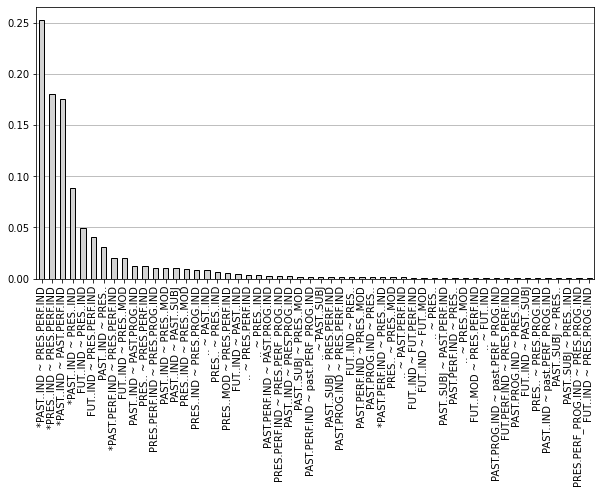

In [165]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_bar_1D(inter_pr, ax)

In [166]:
eng_df.disagree.value_counts()

0    9573
1    2334
Name: disagree, dtype: int64

### Specific verb phrases involved

In [167]:
vp_disag_ct = (disag_df.niv_TAM.value_counts() + disag_df.esv_TAM.value_counts()
vp_disag_ct = vp_disag_ct.sort_values(ascending=False)
vp_disag_pr = prop_table(vp_disag_ct)

vp_disag_ct

SyntaxError: invalid syntax (<ipython-input-167-4a84559d34f2>, line 2)

In [ ]:
vp_disag_pr

Get difference of proportions:

In [ ]:
vp_agree_ct = eng_df[eng_df.disagree == 0].esv_TAM.value_counts()
vp_agree_pr = prop_table(vp_agree_ct)

vp_agree_ct

In [ ]:
vp_agree_pr

In [ ]:
# now difference of proportions from
# when there is agreement
(vp_disag_pr - vp_agree_pr).sort_values(ascending=False)

### Counting agreement

In [ ]:
eng_agree_ct = eng_df.disagree.value_counts()
eng_agree_pr = prop_table(eng_agree_ct)

eng_agree_ct

In [ ]:
eng_agree_pr

### Disagreement by Genre

In [168]:
ag_genre = Analyze(eng_df[eng_df.genre.isin(main_genre)], index='genre', columns='disagree', fishers=False)

ag_genre.show()

counts:


disagree,0,1
genre,,
prose,4631,934
prophetic,2518,773
poetry,1824,495



proportions 1:


disagree,0,1
genre,,
prose,0.832165,0.167835
prophetic,0.765117,0.234883
poetry,0.786546,0.213454



proportions 2:


genre,prose,prophetic,poetry
disagree,,,
0,0.516104,0.280620,0.203276
1,0.424160,0.351045,0.224796


In [169]:
# difference proportions between agree/disagree
dp_agree = ag_genre.pr2.loc[1] - ag_genre.pr2.loc[0]

dp_agree

genre
prose       -0.091944
prophetic    0.070425
poetry       0.021519
dtype: float64

In [170]:
dp_agree['poetry'] + dp_agree['prophetic']

0.0919440124794608

In [171]:
ag_genre.oneN

disagree,0,1
genre,,
prose,1.201684,5.958244
prophetic,1.306990,4.257439
poetry,1.271382,4.684848


### Disagreement by Domain

counts:


disagree,0,1
domain2,,
Q,6363,1789
N,2428,459
?,639,56
D,143,30



proportions 1:


disagree,0,1
domain2,,
Q,0.780545,0.219455
N,0.841011,0.158989
?,0.919424,0.080576
D,0.826590,0.173410



proportions 2:


domain2,Q,N,?,D
disagree,,,,
0,0.664682,0.253630,0.066750,0.014938
1,0.766495,0.196658,0.023993,0.012853



Fisher's test with log transform:


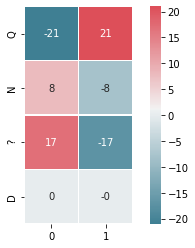

In [172]:
disc_disag = Analyze(eng_df, index='domain2', columns='disagree')

disc_disag.show()

In [173]:
# diff in prop by genre between N and Q
disc_disag.pr.loc['Q'] - disc_disag.pr.loc['N']

disagree
0   -0.060467
1    0.060467
dtype: float64

In [174]:
# diff in prop by agreement
disc_disag.pr2.loc[1] - disc_disag.pr2.loc[0]

domain2
Q    0.101813
N   -0.056972
?   -0.042757
D   -0.002084
dtype: float64

### Disagreement by Genre + Domain

counts:


disagree              0    1
genre     domain2           
prophetic Q        2196  718
prose     Q        2319  525
          N        2049  389
poetry    Q        1621  466
prophetic N         121   32
poetry    N          24    5


proportions 1:



proportions 2:



Fisher's test with log transform:


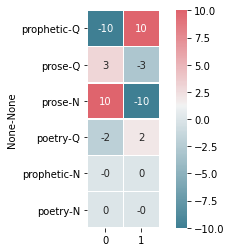

In [175]:
ag_gendom = Analyze(
    eng_df[(eng_df.domain2.isin(main_dom)) & (eng_df.genre.isin(main_genre))], 
    index=['genre', 'domain2'],
    columns='disagree',
)

ag_gendom.show()

In [176]:
# dif of props
ag_gendom.pr2.loc[1] - ag_gendom.pr2.loc[0]

genre      domain2
prophetic  Q          0.072674
prose      Q         -0.032490
           N         -0.063777
poetry     Q          0.023669
prophetic  N          0.000462
poetry     N         -0.000539
dtype: float64

### TAM interchanges by Genre

counts:


TAM_inter,*PAST..IND ~ PRES.PERF.IND,*PRES..IND ~ PRES.PERF.IND,*PAST..IND ~ PAST.PERF.IND,*PAST..IND ~ PRES..IND,FUT..IND ~ PRES..IND,FUT..IND ~ PRES.PERF.IND,PAST..IND ~ PRES..,*PAST.PERF.IND ~ PRES.PERF.IND,FUT..IND ~ PRES..MOD,PAST..IND ~ PAST.PROG.IND,PRES.. ~ PRES.PERF.IND,PRES.PERF.IND ~ PRES.PROG.IND,PAST..IND ~ PAST..SUBJ,PRES..IND ~ PRES..MOD,PAST..IND ~ PRES..MOD,PRES..IND ~ PRES.PROG.IND,.. ~ PAST..IND,PRES.. ~ PRES..IND,PRES..MOD ~ PRES.PERF.IND,FUT..IND ~ PAST..IND,.. ~ PRES..IND,.. ~ PRES.PERF.IND,PAST.PERF.IND ~ PAST.PROG.IND,PAST..IND ~ PRES.PROG.IND,PRES.PERF.IND ~ PRES.PERF_PROG.IND,PAST.PROG.IND ~ PRES.PERF.IND,PAST..SUBJ ~ PRES..MOD,PAST..SUBJ ~ PRES.PERF.IND,PAST.PERF.IND ~ past.PERF_PROG.IND,PAST.PROG.IND ~ PRES..,.. ~ PAST.PERF.IND,FUT..IND ~ PRES..,.. ~ PAST..SUBJ,*PAST.PERF.IND ~ PRES..IND,PAST.PERF.IND ~ PRES..MOD,PRES.. ~ PRES..MOD,PAST..SUBJ ~ PAST.PERF.IND,PAST.PERF.IND ~ PRES..,FUT..IND ~ FUT.PERF.IND,FUT..IND ~ FUT..MOD,.. ~ PRES..,.. ~ PRES..MOD,.. ~ FUT..IND,PAST.PROG.IND ~ past.PERF_PROG.IND,FUT..IND ~ PAST..SUBJ,PRES.. ~ PRES.PROG.IND,FUT..IND ~ PRES.PROG.IND,FUT..MOD ~ PRES.PERF.IND,FUT.PERF.IND ~ PRES.PERF.IND,PAST..IND ~ past.PERF_PROG.IND,PAST..SUBJ ~ PRES..,PAST..SUBJ ~ PRES..IND,PAST.PROG.IND ~ PRES..IND,PRES.PERF_PROG.IND ~ PRES.PROG.IND
genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
prose,249,75,305,44,12,6,48,34,4,25,14,16,17,6,11,6,10,1,4,0,1,5,6,1,2,3,3,1,4,2,2,0,2,1,2,0,2,2,0,0,0,2,0,1,0,1,0,1,1,1,1,0,0,0
prophetic,180,169,46,61,83,81,11,9,39,3,4,6,5,10,7,12,6,6,3,7,2,2,0,3,2,0,1,3,0,1,1,1,0,0,0,2,0,0,1,2,1,0,1,0,1,0,1,0,0,0,0,0,0,0
poetry,132,148,18,82,20,8,11,5,5,1,9,3,2,7,3,2,2,8,4,3,6,1,0,1,1,1,0,0,0,0,0,2,1,2,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1



proportions 1:


TAM_inter,*PAST..IND ~ PRES.PERF.IND,*PRES..IND ~ PRES.PERF.IND,*PAST..IND ~ PAST.PERF.IND,*PAST..IND ~ PRES..IND,FUT..IND ~ PRES..IND,FUT..IND ~ PRES.PERF.IND,PAST..IND ~ PRES..,*PAST.PERF.IND ~ PRES.PERF.IND,FUT..IND ~ PRES..MOD,PAST..IND ~ PAST.PROG.IND,PRES.. ~ PRES.PERF.IND,PRES.PERF.IND ~ PRES.PROG.IND,PAST..IND ~ PAST..SUBJ,PRES..IND ~ PRES..MOD,PAST..IND ~ PRES..MOD,PRES..IND ~ PRES.PROG.IND,.. ~ PAST..IND,PRES.. ~ PRES..IND,PRES..MOD ~ PRES.PERF.IND,FUT..IND ~ PAST..IND,.. ~ PRES..IND,.. ~ PRES.PERF.IND,PAST.PERF.IND ~ PAST.PROG.IND,PAST..IND ~ PRES.PROG.IND,PRES.PERF.IND ~ PRES.PERF_PROG.IND,PAST.PROG.IND ~ PRES.PERF.IND,PAST..SUBJ ~ PRES..MOD,PAST..SUBJ ~ PRES.PERF.IND,PAST.PERF.IND ~ past.PERF_PROG.IND,PAST.PROG.IND ~ PRES..,.. ~ PAST.PERF.IND,FUT..IND ~ PRES..,.. ~ PAST..SUBJ,*PAST.PERF.IND ~ PRES..IND,PAST.PERF.IND ~ PRES..MOD,PRES.. ~ PRES..MOD,PAST..SUBJ ~ PAST.PERF.IND,PAST.PERF.IND ~ PRES..,FUT..IND ~ FUT.PERF.IND,FUT..IND ~ FUT..MOD,.. ~ PRES..,.. ~ PRES..MOD,.. ~ FUT..IND,PAST.PROG.IND ~ past.PERF_PROG.IND,FUT..IND ~ PAST..SUBJ,PRES.. ~ PRES.PROG.IND,FUT..IND ~ PRES.PROG.IND,FUT..MOD ~ PRES.PERF.IND,FUT.PERF.IND ~ PRES.PERF.IND,PAST..IND ~ past.PERF_PROG.IND,PAST..SUBJ ~ PRES..,PAST..SUBJ ~ PRES..IND,PAST.PROG.IND ~ PRES..IND,PRES.PERF_PROG.IND ~ PRES.PROG.IND
genre,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
prose,0.266595,0.080300,0.326552,0.047109,0.012848,0.006424,0.051392,0.036403,0.004283,0.026767,0.014989,0.017131,0.018201,0.006424,0.011777,0.006424,0.010707,0.001071,0.004283,0.000000,0.001071,0.005353,0.006424,0.001071,0.002141,0.003212,0.003212,0.001071,0.004283,0.002141,0.002141,0.000000,0.002141,0.001071,0.002141,0.000000,0.002141,0.002141,0.000000,0.000000,0.000000,0.002141,0.000000,0.001071,0.000000,0.001071,0.000000,0.001071,0.001071,0.001071,0.001071,0.000000,0.000000,0.000000
prophetic,0.232859,0.218629,0.059508,0.078913,0.107374,0.104787,0.014230,0.011643,0.050453,0.003881,0.005175,0.007762,0.006468,0.012937,0.009056,0.015524,0.007762,0.007762,0.003881,0.009056,0.002587,0.002587,0.000000,0.003881,0.002587,0.000000,0.001294,0.003881,0.000000,0.001294,0.001294,0.001294,0.000000,0.000000,0.000000,0.002587,0.000000,0.000000,0.001294,0.002587,0.001294,0.000000,0.001294,0.000000,0.001294,0.000000,0.001294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
poetry,0.266667,0.298990,0.036364,0.165657,0.040404,0.016162,0.022222,0.010101,0.010101,0.002020,0.018182,0.006061,0.004040,0.014141,0.006061,0.004040,0.004040,0.016162,0.008081,0.006061,0.012121,0.002020,0.000000,0.002020,0.002020,0.002020,0.000000,0.000000,0.000000,0.000000,0.000000,0.004040,0.002020,0.004040,0.002020,0.002020,0.000000,0.000000,0.002020,0.000000,0.002020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002020,0.002020,0.002020



proportions 2:


genre,prose,prophetic,poetry
TAM_inter,,,
*PAST..IND ~ PRES.PERF.IND,0.443850,0.320856,0.235294
*PRES..IND ~ PRES.PERF.IND,0.191327,0.431122,0.377551
*PAST..IND ~ PAST.PERF.IND,0.826558,0.124661,0.048780
*PAST..IND ~ PRES..IND,0.235294,0.326203,0.438503
FUT..IND ~ PRES..IND,0.104348,0.721739,0.173913
FUT..IND ~ PRES.PERF.IND,0.063158,0.852632,0.084211
PAST..IND ~ PRES..,0.685714,0.157143,0.157143
*PAST.PERF.IND ~ PRES.PERF.IND,0.708333,0.187500,0.104167
FUT..IND ~ PRES..MOD,0.083333,0.812500,0.104167



Fisher's test with log transform:


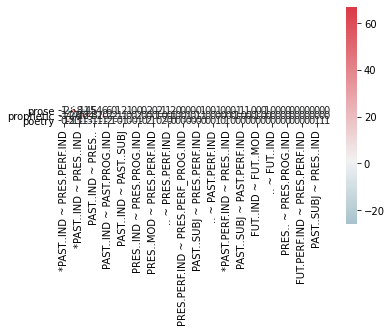

In [177]:
gen_tami = Analyze(eng_df[eng_df.genre.isin(main_genre)], index='genre', columns='TAM_inter')

gen_tami.show()

In [178]:
gen_tami_pr2_2 = gen_tami.pr2.iloc[:,:1].copy()
gen_tami_pr2_2['poetry+prophecy'] = gen_tami.pr2.iloc[:,1] + gen_tami.pr2.iloc[:,2]

max_highlighter(gen_tami_pr2_2)

genre,prose,poetry+prophecy
TAM_inter,,
*PAST..IND ~ PRES.PERF.IND,0.443850,0.556150
*PRES..IND ~ PRES.PERF.IND,0.191327,0.808673
*PAST..IND ~ PAST.PERF.IND,0.826558,0.173442
*PAST..IND ~ PRES..IND,0.235294,0.764706
FUT..IND ~ PRES..IND,0.104348,0.895652
FUT..IND ~ PRES.PERF.IND,0.063158,0.936842
PAST..IND ~ PRES..,0.685714,0.314286
*PAST.PERF.IND ~ PRES.PERF.IND,0.708333,0.291667
FUT..IND ~ PRES..MOD,0.083333,0.916667


In [186]:
#ts.show(eng_df[eng_df.TAM_inter == '*PAST..IND ~ PRES..IND'], spread=10)

showing 10 of 207


,ref,text_full,sentence,esv_TAMspan,esv_TAM,niv_TAMspan,niv_TAM
bhsa_node,,,,,,,
1396,Genesis 3:12,נָתַ֣תָּה,הָֽאִשָּׁה֙ אֲשֶׁ֣ר נָתַ֣תָּה עִמָּדִ֔י הִ֛וא נָֽתְנָה־לִּ֥י מִן־הָעֵ֖ץ וָאֹכֵֽל׃,gave,PAST..IND,put,PRES..IND
85336,Numbers 24:9,כָּרַ֨ע,כָּרַ֨ע,crouched,PAST..IND,crouch,PRES..IND
138884,Judges 18:23,נִזְעָֽקְתָּ,כִּ֥י נִזְעָֽקְתָּ׃,come,PRES..IND,called,PAST..IND
218805,Isaiah 21:6,אָמַ֛ר,כִּ֣י כֹ֥ה אָמַ֛ר אֵלַ֖י אֲדֹנָ֑י,said,PAST..IND,says,PRES..IND
239944,Jeremiah 10:3,כְּרָתֹ֔ו,כִּֽי־עֵץ֙ מִיַּ֣עַר כְּרָתֹ֔ו,is,PRES..IND,cut,PAST..IND
292427,Hosea 7:5,הֶחֱל֥וּ,יֹ֣ום מַלְכֵּ֔נוּ הֶחֱל֥וּ שָׂרִ֖ים חֲמַ֣ת מִיָּ֑יִן,became,PAST..IND,become,PRES..IND
319572,Psalms 55:21,חִלֵּ֥ל,חִלֵּ֥ל בְּרִיתֹֽו׃,violated,PAST..IND,violates,PRES..IND
334785,Psalms 141:6,נָעֵֽמוּ,וְשָׁמְע֥וּ אֲ֝מָרַ֗י כִּ֣י נָעֵֽמוּ׃,are,PRES..IND,were,PAST..IND
360332,Ecclesiastes 3:14,יָדַ֗עְתִּי,יָדַ֗עְתִּי כִּ֠י כָּל־אֲשֶׁ֨ר יַעֲשֶׂ֤ה הָאֱלֹהִים֙ ה֚וּא יִהְיֶ֣ה לְעֹולָ֔ם,perceived,PAST..IND,know,PRES..IND


In [180]:
# # involving the future

# fut_tcases = eng_df[
#     (eng_df.TAM_inter == 'FUT..IND ~ PRES..IND')
#     | (eng_df.TAM_inter == 'FUT..IND ~ PRES.PERF.IND')
# ]

# ts_tr.show(fut_tcases, spread=10, extra=['clause'])

In [193]:
# involving simple past and present perfect

ts_tr.show(eng_df[
    (eng_df.TAM_inter == '*PAST..IND ~ PRES.PERF.IND')
], spread=10)

showing 10 of 590


,ref,text_full,sentence,esv_TAMspan,esv_TAM,esv_verse,niv_TAMspan,niv_TAM,niv_verse
bhsa_node,,,,,,,,,
1503,Genesis 3:17,שָׁמַעְתָּ֮,כִּ֥י־שָׁמַעְתָּ֮ לְקֹ֣ול אִשְׁתֶּךָ֒,have listened,PRES.PERF.IND,"And to Adam he said , “ Because you have listened to the voice of your wife and have eaten of the tree of which I commanded you , ‘ You shall not eat of it , ’ cursed is the ground because of you ; in pain you shall eat of it all the days of your life ;",listened,PAST..IND,"To Adam he said , “ Because you listened to your wife and ate from the tree about which I commanded you , ‘ You must not eat of it , ’ “ Cursed is the ground because of you ; through painful toil you will eat of it all the days of your life ."
79870,Numbers 15:31,הֵפַ֑ר,וְאֶת־מִצְוָתֹ֖ו הֵפַ֑ר,has broken,PRES.PERF.IND,"Because he has despised the word of the Lord and has broken his commandment , that person shall be utterly cut off ; his iniquity shall be on him . ”",broken,PAST..IND,"Because he has despised the LORD’s word and broken his commands , that person must surely be cut off ; his guilt remains on him . ’ ”"
125269,Joshua 22:2,צִוִּ֖יתִי,וַתִּשְׁמְע֣וּ בְקֹולִ֔י לְכֹ֥ל אֲשֶׁר־צִוִּ֖יתִי אֶתְכֶֽם׃,have commanded,PRES.PERF.IND,"and said to them , “ You have kept all that Moses the servant of the Lord commanded you and have obeyed my voice in all that I have commanded you .",commanded,PAST..IND,"and said to them , “ You have done all that Moses the servant of the LORD commanded , and you have obeyed me in everything I commanded ."
166580,2_Samuel 12:9,הִכִּ֣יתָ,אֵ֣ת אוּרִיָּ֤ה הַֽחִתִּי֙ הִכִּ֣יתָ בַחֶ֔רֶב,have struck,PRES.PERF.IND,"Why have you despised the word of the Lord , to do what is evil in his sight ? You have struck down Uriah the Hittite with the sword and have taken his wife to be your wife and have killed him with the sword of the Ammonites .",struck,PAST..IND,Why did you despise the word of the LORD by doing what is evil in his eyes ? You struck down Uriah the Hittite with the sword and took his wife to be your own . You killed him with the sword of the Ammonites .
220220,Isaiah 25:9,קִוִּ֥ינוּ,קִוִּ֥ינוּ לֹ֖ו,have waited,PRES.PERF.IND,"It will be said on that day , “ Behold , this is our God ; we have waited for him , that he might save us . This is the Lord ; we have waited for him ; let us be glad and rejoice in his salvation . ”",trusted,PAST..IND,"In that day they will say , “ Surely this is our God ; we trusted in him , and he saved us . This is the LORD , we trusted in him ; let us rejoice and be glad in his salvation . ”"
246427,Jeremiah 23:25,חָלָֽמְתִּי,חָלָֽמְתִּי׃,have dreamed,PRES.PERF.IND,"I have heard what the prophets have said who prophesy lies in my name , saying , ‘ I have dreamed , I have dreamed ! ’",had,PAST..IND,"“ I have heard what the prophets say who prophesy lies in my name . They say , ‘ I had a dream ! I had a dream ! ’"
279976,Ezekiel 31:11,גֵּרַשְׁתִּֽהוּ,גֵּרַשְׁתִּֽהוּ׃,have cast,PRES.PERF.IND,I will give it into the hand of a mighty one of the nations . He shall surely deal with it as its wickedness deserves . I have cast it out .,cast,PAST..IND,"I handed it over to the ruler of the nations , for him to deal with according to its wickedness . I cast it aside ,"
322960,Psalms 74:17,יְצַרְתָּם,קַ֥יִץ וָ֝חֹ֗רֶף אַתָּ֥ה יְצַרְתָּם׃,have made,PRES.PERF.IND,You have fixed all the boundaries of the earth ; you have made summer and winter .,made,PAST..IND,It was you who set all the boundaries of the earth ; you made both summer and winter .
363707,Lamentations 1:10,רָאֲתָ֤ה,כִּֽי־רָאֲתָ֤ה גֹויִם֙ בָּ֣אוּ מִקְדָּשָׁ֔הּ אֲשֶׁ֣ר צִוִּ֔יתָה לֹא־יָבֹ֥אוּ בַקָּהָ֖ל לָֽךְ׃ ס,has seen,PRES.PERF.IND,"The enemy has stretched out his hands over all her precious things ; for she has seen the nations enter her sanctuary , those whom you forbade to enter your congregation .",saw,PAST..IND,The enemy laid hands on all her treasures ; she saw pagan nations enter her sanctuary — those you had forbidden to enter your assembly .


In [194]:
# involving simple past and present perfect

ts_tr.show(eng_df[
    (eng_df.TAM_inter == '*PAST..IND ~ PAST.PERF.IND')
], spread=10)

showing 10 of 409


,ref,text_full,sentence,esv_TAMspan,esv_TAM,esv_verse,niv_TAMspan,niv_TAM,niv_verse
bhsa_node,,,,,,,,,
1221,Genesis 3:3,אָמַ֣ר,אָמַ֣ר אֱלֹהִ֗ים,said,PAST..IND,"but God said , ‘ You shall not eat of the fruit of the tree that is in the midst of the garden , neither shall you touch it , lest you die . ’ ”",did say,PAST.PERF.IND,"but God did say , ‘ You must not eat fruit from the tree that is in the middle of the garden , and you must not touch it , or you will die . ’ ”"
39442,Exodus 19:18,יָרַ֥ד,מִ֠פְּנֵי אֲשֶׁ֨ר יָרַ֥ד עָלָ֛יו יְהוָ֖ה בָּאֵ֑שׁ,had descended,PAST.PERF.IND,"Now Mount Sinai was wrapped in smoke because the Lord had descended on it in fire . The smoke of it went up like the smoke of a kiln , and the whole mountain trembled greatly .",descended,PAST..IND,"Mount Sinai was covered with smoke , because the LORD descended on it in fire . The smoke billowed up from it like smoke from a furnace , the whole mountain trembled violently ,"
114377,Joshua 3:17,תַּ֨מּוּ֙,וַיַּעַמְד֣וּ הַכֹּהֲנִ֡ים נֹ֠שְׂאֵי הָאָרֹ֨ון בְּרִית־יְהוָ֜ה בֶּחָֽרָבָ֛ה בְּתֹ֥וךְ הַיַּרְדֵּ֖ן הָכֵ֑ן עַ֤ד אֲשֶׁר־תַּ֨מּוּ֙ כָּל־הַגֹּ֔וי לַעֲבֹ֖ר אֶת־הַיַּרְדֵּֽן׃,finished,PAST..IND,"Now the priests bearing the ark of the covenant of the Lord stood firmly on dry ground in the midst of the Jordan , and all Israel was passing over on dry ground until all the nation finished passing over the Jordan .",had completed,PAST.PERF.IND,"The priests who carried the ark of the covenant of the LORD stood firm on dry ground in the middle of the Jordan , while all Israel passed by until the whole nation had completed the crossing on dry ground ."
127403,Joshua 24:32,הֶעֱל֨וּ,וְאֶת־עַצְמֹ֣ות יֹ֠וסֵף אֲשֶׁר־הֶעֱל֨וּ בְנֵי־יִשְׂרָאֵ֥ל׀ מִמִּצְרַיִם֮ קָבְר֣וּ בִשְׁכֶם֒ בְּחֶלְקַ֣ת הַשָּׂדֶ֗ה אֲשֶׁ֨ר קָנָ֧ה יַעֲקֹ֛ב מֵאֵ֛ת בְּנֵֽי־חֲמֹ֥ור אֲבִֽי־שְׁכֶ֖ם בְּמֵאָ֣ה קְשִׂיטָ֑ה וַיִּֽהְי֥וּ לִבְנֵֽי־יֹוסֵ֖ף לְנַחֲלָֽה׃,brought,PAST..IND,"As for the bones of Joseph , which the people of Israel brought up from Egypt , they buried them at Shechem , in the piece of land that Jacob bought from the sons of Hamor the father of Shechem for a hundred pieces of money . It became an inheritance of the descendants of Joseph .",had brought,PAST.PERF.IND,"And Joseph’s bones , which the Israelites had brought up from Egypt , were buried at Shechem in the tract of land that Jacob bought for a hundred pieces of silver from the sons of Hamor , the father of Shechem . This became the inheritance of Joseph’s descendants ."
169596,2_Samuel 15:31,הִגִּ֣יד,וְדָוִד֙ הִגִּ֣יד לֵאמֹ֔ר,was,PAST..IND,"And it was told David , “ Ahithophel is among the conspirators with Absalom . ” And David said , “ O Lord , please turn the counsel of Ahithophel into foolishness . ”",had been,PAST.PERF.IND,"Now David had been told , “ Ahithophel is among the conspirators with Absalom . ” So David prayed , “ O LORD , turn Ahithophel’s counsel into foolishness . ”"
189477,1_Kings 16:19,עָשָׂ֔ה,וַיָּמֹֽת׃ עַל־חַטֹּאתָיו֙ אֲשֶׁ֣ר חָטָ֔א לַעֲשֹׂ֥ות הָרַ֖ע בְּעֵינֵ֣י יְהוָ֑ה לָלֶ֨כֶת֙ בְּדֶ֣רֶךְ יָרָבְעָ֔ם וּבְחַטָּאתֹו֙ אֲשֶׁ֣ר עָשָׂ֔ה לְהַחֲטִ֖יא אֶת־יִשְׂרָאֵֽל׃,committed,PAST..IND,"because of his sins that he committed , doing evil in the sight of the Lord , walking in the way of Jeroboam , and for his sin which he committed , making Israel to sin .",had committed,PAST.PERF.IND,"because of the sins he had committed , doing evil in the eyes of the LORD and walking in the ways of Jeroboam and in the sin he had committed and had caused Israel to commit ."
210473,2_Kings 23:22,נַֽעֲשָׂה֙,כִּ֣י לֹ֤א נַֽעֲשָׂה֙ כַּפֶּ֣סַח הַזֶּ֔ה מִימֵי֙ הַשֹּׁ֣פְטִ֔ים אֲשֶׁ֥ר שָׁפְט֖וּ אֶת־יִשְׂרָאֵ֑ל וְכֹ֗ל יְמֵ֛י מַלְכֵ֥י יִשְׂרָאֵ֖ל וּמַלְכֵ֥י יְהוּדָֽה׃,had been,PAST.PERF.IND,"For no such Passover had been kept since the days of the judges who judged Israel , or during all the days of the kings of Israel or of the kings of Judah .",had,PAST..IND,"Not since the days of the judges who led Israel , nor throughout the days of the kings of Israel

### TAM interchanges by discourse type

counts:


TAM_inter,*PAST..IND ~ PRES.PERF.IND,*PRES..IND ~ PRES.PERF.IND,*PAST..IND ~ PAST.PERF.IND,*PAST..IND ~ PRES..IND,FUT..IND ~ PRES..IND,FUT..IND ~ PRES.PERF.IND,PAST..IND ~ PRES..,*PAST.PERF.IND ~ PRES.PERF.IND,FUT..IND ~ PRES..MOD,PAST..IND ~ PAST.PROG.IND,PRES.. ~ PRES.PERF.IND,PRES.PERF.IND ~ PRES.PROG.IND,PAST..IND ~ PRES..MOD,PAST..IND ~ PAST..SUBJ,PRES..IND ~ PRES..MOD,PRES..IND ~ PRES.PROG.IND,.. ~ PAST..IND,PRES.. ~ PRES..IND,PRES..MOD ~ PRES.PERF.IND,FUT..IND ~ PAST..IND,.. ~ PRES.PERF.IND,.. ~ PRES..IND,PAST.PERF.IND ~ PAST.PROG.IND,PAST..IND ~ PRES.PROG.IND,PRES.PERF.IND ~ PRES.PERF_PROG.IND,PAST.PROG.IND ~ PRES.PERF.IND,PAST.PERF.IND ~ past.PERF_PROG.IND,PAST..SUBJ ~ PRES..MOD,PAST..SUBJ ~ PRES.PERF.IND,.. ~ PAST..SUBJ,PAST.PROG.IND ~ PRES..,.. ~ PAST.PERF.IND,FUT..IND ~ PRES..,PRES.. ~ PRES..MOD,*PAST.PERF.IND ~ PRES..IND,PAST.PERF.IND ~ PRES..MOD,PAST.PERF.IND ~ PRES..,FUT..IND ~ FUT.PERF.IND,FUT..IND ~ FUT..MOD,.. ~ PRES..,.. ~ PRES..MOD,PAST..SUBJ ~ PAST.PERF.IND,.. ~ FUT..IND,PAST.PROG.IND ~ past.PERF_PROG.IND,FUT..IND ~ PAST..SUBJ,PRES.. ~ PRES.PROG.IND,FUT..IND ~ PRES.PROG.IND,FUT..MOD ~ PRES.PERF.IND,FUT.PERF.IND ~ PRES.PERF.IND,PAST..IND ~ past.PERF_PROG.IND,PAST..SUBJ ~ PRES..,PAST..SUBJ ~ PRES..IND,PAST.PROG.IND ~ PRES..IND,PRES.PERF_PROG.IND ~ PRES.PROG.IND
domain2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Q,575,397,86,180,110,88,26,46,45,7,28,24,11,9,22,20,12,15,11,9,9,8,0,5,5,4,0,4,3,2,0,1,3,3,3,2,0,2,2,2,0,1,1,0,1,1,1,1,1,0,0,1,1,1
N,3,8,297,12,1,6,46,2,0,21,0,0,14,15,1,0,5,1,0,1,0,0,5,0,0,0,4,0,1,2,3,2,0,0,0,1,2,0,0,0,2,1,0,1,0,0,0,0,0,1,1,0,0,0
?,6,10,25,6,2,1,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,6,5,1,9,3,0,0,0,2,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



proportions 1:


TAM_inter,*PAST..IND ~ PRES.PERF.IND,*PRES..IND ~ PRES.PERF.IND,*PAST..IND ~ PAST.PERF.IND,*PAST..IND ~ PRES..IND,FUT..IND ~ PRES..IND,FUT..IND ~ PRES.PERF.IND,PAST..IND ~ PRES..,*PAST.PERF.IND ~ PRES.PERF.IND,FUT..IND ~ PRES..MOD,PAST..IND ~ PAST.PROG.IND,PRES.. ~ PRES.PERF.IND,PRES.PERF.IND ~ PRES.PROG.IND,PAST..IND ~ PRES..MOD,PAST..IND ~ PAST..SUBJ,PRES..IND ~ PRES..MOD,PRES..IND ~ PRES.PROG.IND,.. ~ PAST..IND,PRES.. ~ PRES..IND,PRES..MOD ~ PRES.PERF.IND,FUT..IND ~ PAST..IND,.. ~ PRES.PERF.IND,.. ~ PRES..IND,PAST.PERF.IND ~ PAST.PROG.IND,PAST..IND ~ PRES.PROG.IND,PRES.PERF.IND ~ PRES.PERF_PROG.IND,PAST.PROG.IND ~ PRES.PERF.IND,PAST.PERF.IND ~ past.PERF_PROG.IND,PAST..SUBJ ~ PRES..MOD,PAST..SUBJ ~ PRES.PERF.IND,.. ~ PAST..SUBJ,PAST.PROG.IND ~ PRES..,.. ~ PAST.PERF.IND,FUT..IND ~ PRES..,PRES.. ~ PRES..MOD,*PAST.PERF.IND ~ PRES..IND,PAST.PERF.IND ~ PRES..MOD,PAST.PERF.IND ~ PRES..,FUT..IND ~ FUT.PERF.IND,FUT..IND ~ FUT..MOD,.. ~ PRES..,.. ~ PRES..MOD,PAST..SUBJ ~ PAST.PERF.IND,.. ~ FUT..IND,PAST.PROG.IND ~ past.PERF_PROG.IND,FUT..IND ~ PAST..SUBJ,PRES.. ~ PRES.PROG.IND,FUT..IND ~ PRES.PROG.IND,FUT..MOD ~ PRES.PERF.IND,FUT.PERF.IND ~ PRES.PERF.IND,PAST..IND ~ past.PERF_PROG.IND,PAST..SUBJ ~ PRES..,PAST..SUBJ ~ PRES..IND,PAST.PROG.IND ~ PRES..IND,PRES.PERF_PROG.IND ~ PRES.PROG.IND
domain2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Q,0.321409,0.221912,0.048072,0.100615,0.061487,0.049189,0.014533,0.025713,0.025154,0.003913,0.015651,0.013415,0.006149,0.005031,0.012297,0.011179,0.006708,0.008385,0.006149,0.005031,0.005031,0.004472,0.000000,0.002795,0.002795,0.002236,0.000000,0.002236,0.001677,0.001118,0.000000,0.000559,0.001677,0.001677,0.001677,0.001118,0.000000,0.001118,0.001118,0.001118,0.000000,0.000559,0.000559,0.000000,0.000559,0.000559,0.000559,0.000559,0.000559,0.000000,0.000000,0.000559,0.000559,0.000559
N,0.006536,0.017429,0.647059,0.026144,0.002179,0.013072,0.100218,0.004357,0.000000,0.045752,0.000000,0.000000,0.030501,0.032680,0.002179,0.000000,0.010893,0.002179,0.000000,0.002179,0.000000,0.000000,0.010893,0.000000,0.000000,0.000000,0.008715,0.000000,0.002179,0.004357,0.006536,0.004357,0.000000,0.000000,0.000000,0.002179,0.004357,0.000000,0.000000,0.000000,0.004357,0.002179,0.000000,0.002179,0.000000,0.000000,0.000000,0.000000,0.000000,0.002179,0.002179,0.000000,0.000000,0.000000
?,0.107143,0.178571,0.446429,0.107143,0.035714,0.017857,0.017857,0.000000,0.017857,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.017857,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
D,0.200000,0.166667,0.033333,0.300000,0.100000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



proportions 2:


domain2,Q,N,?,D
TAM_inter,,,,
*PAST..IND ~ PRES.PERF.IND,0.974576,0.005085,0.010169,0.010169
*PRES..IND ~ PRES.PERF.IND,0.945238,0.019048,0.023810,0.011905
*PAST..IND ~ PAST.PERF.IND,0.210269,0.726161,0.061125,0.002445
*PAST..IND ~ PRES..IND,0.869565,0.057971,0.028986,0.043478
FUT..IND ~ PRES..IND,0.948276,0.008621,0.017241,0.025862
FUT..IND ~ PRES.PERF.IND,0.926316,0.063158,0.010526,0.000000
PAST..IND ~ PRES..,0.356164,0.630137,0.013699,0.000000
*PAST.PERF.IND ~ PRES.PERF.IND,0.958333,0.041667,0.000000,0.000000
FUT..IND ~ PRES..MOD,0.937500,0.000000,0.020833,0.041667



Fisher's test with log transform:


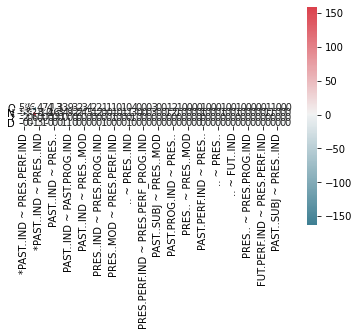

In [182]:
disc_tami = Analyze(eng_df, index='domain2', columns='TAM_inter')

disc_tami.show()

## English TAM by Context

In [183]:
engag_df = eng_df[eng_df.disagree == 0]

engdat = AnalysisSet(
    ['genre', [engag_df[engag_df.genre.isin(main_genre)]], {'index': 'esv_TAM', 'columns':'genre'}],
    ['domain', [engag_df], {'index': 'esv_TAM', 'columns': 'domain2'}],
    ['period', [engag_df], {'index': 'esv_TAM', 'columns': 'period'}],
    [
        'pergen', 
        [engag_df[engag_df.genre.isin(main_genre)]], 
        {'index': 'esv_TAM', 'columns': ['period', 'genre']}
    ],
    [
        'perdom', 
        [engag_df[(engag_df.genre.isin(main_genre)) & (engag_df.domain2.isin(main_dom))]],
        {'index': 'esv_TAM', 'columns': ['period', 'domain2']},
    ],
    [
        'gendom', 
        [engag_df[(engag_df.domain2.isin(main_dom)) & (engag_df.genre.isin(main_genre))]], 
        {'index': ['genre','domain2'], 'columns': 'esv_TAM'},
    ],
    [
        'vstem',
        [engag_df],
        {'index': ['esv_TAM'], 'columns':['stem']}
    ],
    [
        'vlex',
        [engag_df],
        {'index': ['esv_TAM'], 'columns':['lex', 'stem']}
    ],
    [
        'vpers',
        [engag_df],
        {'index': ['esv_TAM'], 'columns': ['person']}
    ],
)

setting up analyses...
	done!


### Genre

counts:


genre,prose,prophetic,poetry
esv_TAM,,,
PAST..IND,2472,703,559
PRES.PERF.IND,1031,720,468
PRES..IND,350,940,723
PAST.PERF.IND,654,73,30
FUT..IND,11,45,10
PAST..SUBJ,37,8,15
PRES..MOD,36,7,9
PRES..,10,12,9
PRES.PROG.IND,12,5,1



proportions 1:


genre,prose,prophetic,poetry
esv_TAM,,,
PAST..IND,0.662025,0.188270,0.149705
PRES.PERF.IND,0.464624,0.324470,0.210906
PRES..IND,0.173870,0.466965,0.359165
PAST.PERF.IND,0.863937,0.096433,0.039630
FUT..IND,0.166667,0.681818,0.151515
PAST..SUBJ,0.616667,0.133333,0.250000
PRES..MOD,0.692308,0.134615,0.173077
PRES..,0.322581,0.387097,0.290323
PRES.PROG.IND,0.666667,0.277778,0.055556



proportions 2:


esv_TAM,PAST..IND,PRES.PERF.IND,PRES..IND,PAST.PERF.IND,FUT..IND,PAST..SUBJ,PRES..MOD,PRES..,PRES.PROG.IND,PAST.PROG.IND,..,past.PERF_PROG.IND,FUT.PERF.IND,PRES.PERF_PROG.IND
genre,,,,,,,,,,,,,,
prose,0.533794,0.222630,0.075578,0.141222,0.002375,0.007990,0.007774,0.002159,0.002591,0.002591,0.000648,0.000432,0.000000,0.000216
prophetic,0.279190,0.285941,0.373312,0.028991,0.017871,0.003177,0.002780,0.004766,0.001986,0.000397,0.000794,0.000000,0.000794,0.000000
poetry,0.306469,0.256579,0.396382,0.016447,0.005482,0.008224,0.004934,0.004934,0.000548,0.000000,0.000000,0.000000,0.000000,0.000000



Fisher's test with log transform:


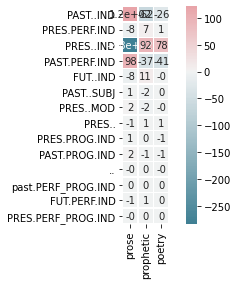

In [184]:
engdat.genre.show()

In [185]:
# How much of present tense is in prophecy + poetry?
engdat.genre.pr.loc['PRES..IND']['prophetic'] + engdat.genre.pr.loc['PRES..IND']['poetry']

0.8261301539990065

In [71]:
# average poetry/prophecy translation tendencies
engdat.genre.pr2.loc[['prophetic', 'poetry']].mean()

esv_TAM
PAST..IND             0.292830
PRES.PERF.IND         0.271260
PRES..IND             0.384847
PAST.PERF.IND         0.022719
FUT..IND              0.011677
PAST..SUBJ            0.005700
PRES..MOD             0.003857
PRES..                0.004850
PRES.PROG.IND         0.001267
PAST.PROG.IND         0.000199
..                    0.000397
past.PERF_PROG.IND    0.000000
FUT.PERF.IND          0.000397
PRES.PERF_PROG.IND    0.000000
dtype: float64

In [191]:
engdat.genre.fish

,prose,prophetic,poetry
PAST..IND,121.310908,-61.724743,-26.283741
PRES.PERF.IND,-7.630562,6.777004,0.520717
PRES..IND,-282.325424,92.110645,78.247332
PAST.PERF.IND,97.903839,-37.301404,-41.033127
FUT..IND,-8.214006,10.888186,-0.446498
PAST..SUBJ,0.913883,-2.039665,0.470209
PRES..MOD,1.925805,-1.714394,-0.136765
PRES..,-1.338011,0.642323,0.583833
PRES.PROG.IND,0.616516,0.000000,-0.828111
PAST.PROG.IND,2.444332,-0.892209,-1.074379


### domain

counts:


domain2,Q,N,?,D
esv_TAM,,,,
PAST..IND,1960,1729,379,48
PRES.PERF.IND,2258,14,42,40
PRES..IND,1823,28,170,41
PAST.PERF.IND,143,592,38,9
FUT..IND,62,0,4,3
PAST..SUBJ,40,20,0,2
PRES..MOD,25,26,4,0
PRES..,22,9,1,0
PRES.PROG.IND,18,0,0,0



proportions 1:


domain2,Q,N,?,D
esv_TAM,,,,
PAST..IND,0.476190,0.420068,0.092080,0.011662
PRES.PERF.IND,0.959218,0.005947,0.017842,0.016992
PRES..IND,0.884093,0.013579,0.082444,0.019884
PAST.PERF.IND,0.182864,0.757033,0.048593,0.011509
FUT..IND,0.898551,0.000000,0.057971,0.043478
PAST..SUBJ,0.645161,0.322581,0.000000,0.032258
PRES..MOD,0.454545,0.472727,0.072727,0.000000
PRES..,0.687500,0.281250,0.031250,0.000000
PRES.PROG.IND,1.000000,0.000000,0.000000,0.000000



proportions 2:


esv_TAM,PAST..IND,PRES.PERF.IND,PRES..IND,PAST.PERF.IND,FUT..IND,PAST..SUBJ,PRES..MOD,PRES..,PRES.PROG.IND,PAST.PROG.IND,..,past.PERF_PROG.IND,FUT.PERF.IND,PRES.PERF_PROG.IND
domain2,,,,,,,,,,,,,,
Q,0.308031,0.354864,0.286500,0.022474,0.009744,0.006286,0.003929,0.003457,0.002829,0.000786,0.000629,0.000000,0.000314,0.000157
N,0.712109,0.005766,0.011532,0.243822,0.000000,0.008237,0.010708,0.003707,0.000000,0.002883,0.000412,0.000824,0.000000,0.000000
?,0.593114,0.065728,0.266041,0.059468,0.006260,0.000000,0.006260,0.001565,0.000000,0.001565,0.000000,0.000000,0.000000,0.000000
D,0.335664,0.279720,0.286713,0.062937,0.020979,0.013986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Fisher's test with log transform:


,Q,N,?,D
PAST..IND,-253.437958,232.649369,16.908902,-1.664208
PRES.PERF.IND,inf,-319.884283,-34.126389,0.481796
PRES..IND,142.710099,-247.242832,2.775816,1.393740
PAST.PERF.IND,-184.496131,211.031401,-1.444575,-0.270091
FUT..IND,5.045690,-8.456217,0.000000,1.075861
PAST..SUBJ,-0.103748,0.619071,-1.460601,0.625660
PRES..MOD,-2.842198,3.323603,0.105285,0.000000
PRES..,0.068879,0.162908,-0.141832,0.000000
PRES.PROG.IND,3.102504,-1.952709,-0.201731,0.000000
PAST.PROG.IND,-1.390134,1.582444,0.227031,0.000000


NB: Fisher's test (+/-)np.inf replaced with 300 for plotting

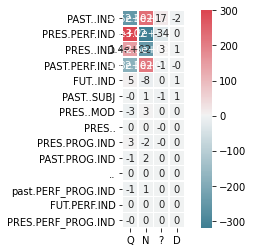

In [158]:
engdat.domain.show()

### period

counts:


period,EBH,LBH
esv_TAM,,
PAST..IND,2139,728
PRES.PERF.IND,972,171
PAST.PERF.IND,472,189
PRES..IND,335,57
PRES..MOD,30,10
PAST..SUBJ,32,7
FUT..IND,12,2
PRES..,10,1
PAST.PROG.IND,9,2



proportions 1:


period,EBH,LBH
esv_TAM,,
PAST..IND,0.746076,0.253924
PRES.PERF.IND,0.850394,0.149606
PAST.PERF.IND,0.714070,0.285930
PRES..IND,0.854592,0.145408
PRES..MOD,0.750000,0.250000
PAST..SUBJ,0.820513,0.179487
FUT..IND,0.857143,0.142857
PRES..,0.909091,0.090909
PAST.PROG.IND,0.818182,0.181818



proportions 2:


esv_TAM,PAST..IND,PRES.PERF.IND,PAST.PERF.IND,PRES..IND,PRES..MOD,PAST..SUBJ,FUT..IND,PRES..,PAST.PROG.IND,PRES.PROG.IND,past.PERF_PROG.IND,PRES.PERF_PROG.IND,..
period,,,,,,,,,,,,,
EBH,0.531957,0.241731,0.117384,0.083313,0.007461,0.007958,0.002984,0.002487,0.002238,0.001741,0.000249,0.000249,0.000249
LBH,0.621691,0.146029,0.161401,0.048676,0.008540,0.005978,0.001708,0.000854,0.001708,0.002562,0.000854,0.000000,0.000000



Fisher's test with log transform:


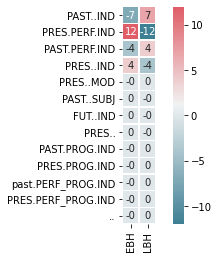

In [159]:
engdat.period.show()

In [161]:
engdat.period.pr2.loc['LBH'] - engdat.period.pr2.loc['EBH'] # compare change to LBH

esv_TAM
PAST..IND             0.089734
PRES.PERF.IND        -0.095702
PAST.PERF.IND         0.044017
PRES..IND            -0.034636
PRES..MOD             0.001079
PAST..SUBJ           -0.001980
FUT..IND             -0.001276
PRES..               -0.001633
PAST.PROG.IND        -0.000530
PRES.PROG.IND         0.000821
past.PERF_PROG.IND    0.000605
PRES.PERF_PROG.IND   -0.000249
..                   -0.000249
dtype: float64

### Period + Genre

In [ ]:
engdat.pergen.show()

In [ ]:
ts.show(eng_df[
    (eng_df.period == 'EBH')
    & (eng_df.genre == 'prophetic')
    & (eng_df.esv_TAM == 'PRES.PERF.IND')
], spread=10)

### period + domain

counts:


period              EBH        LBH     
domain2               Q     N    N    Q
esv_TAM                                
PAST..IND           737  1049  361  138
PRES.PERF.IND       832     5    0  169
PAST.PERF.IND        72   363  150   14
PRES..IND           289     4    2   54
PAST..SUBJ           17    14    4    2
PRES..MOD             9    19    4    1
FUT..IND              9     0    0    2
PRES.PROG.IND         7     0    0    3
PRES..                3     7    0    0
PAST.PROG.IND         2     6    0    2
past.PERF_PROG.IND    0     1    1    0
PRES.PERF_PROG.IND    1     0    0    0
..                    0     1    0    0


proportions 1:



proportions 2:



Fisher's test with log transform:


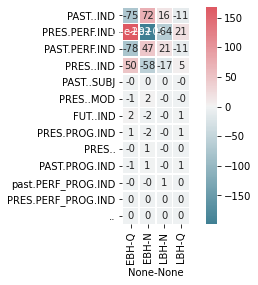

In [208]:
engdat.perdom.show()

In [215]:
engdat.perdom.ct.sum()

period  domain2
EBH     Q          1978
        N          1469
LBH     N           522
        Q           385
dtype: int64

In [218]:
1978 / (1978+1469)

0.5738323179576443

In [219]:
385 / (522 + 385)

0.4244762954796031

In [217]:
engdat.perdom.pr2.sum(1)

period  domain2
EBH     Q          1.0
        N          1.0
LBH     N          1.0
        Q          1.0
dtype: float64

In [209]:
engdat.perdom.fish

EBH                    LBH           
                             Q           N          N          Q
PAST..IND           -75.203769   72.066658  15.606417 -11.108773
PRES.PERF.IND       168.402203 -199.361698 -63.718122  20.574473
PAST.PERF.IND       -77.978321   47.085411  21.231434 -11.148378
PRES..IND            50.006028  -57.581883 -16.748445   4.536855
PAST..SUBJ           -0.000000    0.219594   0.000000  -0.114418
PRES..MOD            -1.439688    2.288296  -0.000000  -0.445193
FUT..IND              1.542035   -1.693902  -0.418933   0.596219
PRES.PROG.IND         0.695897   -1.701041  -0.207756   1.288284
PRES..               -0.439423    1.429557  -0.207756   0.000000
PAST.PROG.IND        -0.907764    1.014193  -0.207756   0.658827
past.PERF_PROG.IND   -0.297514   -0.000000   0.646988   0.000000
PRES.PERF_PROG.IND    0.342662    0.000000   0.000000   0.000000
..                    0.000000    0.471867   0.000000   0.000000

### genre + domain

In [ ]:
engdat.gendom.show()

### Verb stem

counts:


stem,qal,hif,piel,nif,pual,hit,hof,hotp,tif,poel,poal,nit,hsht,etpa
esv_TAM,,,,,,,,,,,,,,
PAST..IND,2704,535,465,289,60,34,22,4,1,1,0,0,0,1
PRES.PERF.IND,1632,284,320,86,14,12,4,1,0,0,1,0,0,0
PRES..IND,1568,95,122,217,36,6,15,1,0,0,0,1,1,0
PAST.PERF.IND,490,121,110,43,5,10,3,0,0,0,0,0,0,0
FUT..IND,39,6,13,9,2,0,0,0,0,0,0,0,0,0
PAST..SUBJ,46,7,7,2,0,0,0,0,0,0,0,0,0,0
PRES..MOD,44,2,6,2,0,0,1,0,0,0,0,0,0,0
PRES..,23,3,5,1,0,0,0,0,0,0,0,0,0,0
PRES.PROG.IND,14,1,1,2,0,0,0,0,0,0,0,0,0,0



proportions 1:


stem,qal,hif,piel,nif,pual,hit,hof,hotp,tif,poel,poal,nit,hsht,etpa
esv_TAM,,,,,,,,,,,,,,
PAST..IND,0.656948,0.129981,0.112974,0.070214,0.014577,0.008260,0.005345,0.000972,0.000243,0.000243,0.000000,0.000000,0.000000,0.000243
PRES.PERF.IND,0.693288,0.120646,0.135939,0.036534,0.005947,0.005098,0.001699,0.000425,0.000000,0.000000,0.000425,0.000000,0.000000,0.000000
PRES..IND,0.760427,0.046072,0.059166,0.105238,0.017459,0.002910,0.007274,0.000485,0.000000,0.000000,0.000000,0.000485,0.000485,0.000000
PAST.PERF.IND,0.626598,0.154731,0.140665,0.054987,0.006394,0.012788,0.003836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FUT..IND,0.565217,0.086957,0.188406,0.130435,0.028986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PAST..SUBJ,0.741935,0.112903,0.112903,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PRES..MOD,0.800000,0.036364,0.109091,0.036364,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PRES..,0.718750,0.093750,0.156250,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PRES.PROG.IND,0.777778,0.055556,0.055556,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



proportions 2:


esv_TAM,PAST..IND,PRES.PERF.IND,PRES..IND,PAST.PERF.IND,FUT..IND,PAST..SUBJ,PRES..MOD,PRES..,PRES.PROG.IND,PAST.PROG.IND,..,past.PERF_PROG.IND,FUT.PERF.IND,PRES.PERF_PROG.IND
stem,,,,,,,,,,,,,,
qal,0.411192,0.248175,0.238443,0.074513,0.005931,0.006995,0.006691,0.003498,0.002129,0.001673,0.000456,0.000304,0.000000,0.000000
hif,0.506149,0.268685,0.089877,0.114475,0.005676,0.006623,0.001892,0.002838,0.000946,0.000000,0.000946,0.000000,0.001892,0.000000
piel,0.442015,0.304183,0.115970,0.104563,0.012357,0.006654,0.005703,0.004753,0.000951,0.000951,0.000951,0.000000,0.000000,0.000951
nif,0.443252,0.131902,0.332822,0.065951,0.013804,0.003067,0.003067,0.001534,0.003067,0.001534,0.000000,0.000000,0.000000,0.000000
pual,0.512821,0.119658,0.307692,0.042735,0.017094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hit,0.548387,0.193548,0.096774,0.161290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hof,0.488889,0.088889,0.333333,0.066667,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hotp,0.666667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tif,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Fisher's test with log transform:


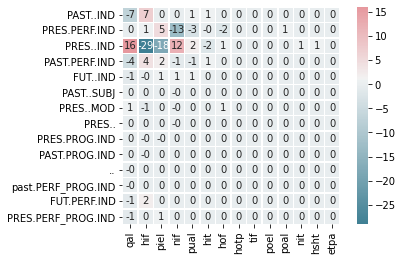

In [238]:
engdat.vstem.show()

### Verb Lexemes

In [72]:
topv = engdat.vlex.ct.sum().head(50).index # top verb lexemes

engdat.vlex.ct[topv]

lex,אמר,עשׂה,היה,נתן,בוא,דבר,צוה,שׁמע,ידע,ראה,שׁלח,מלך,הלך,יצא,לקח,חטא,מצא,שׁבע,קרא,שׂים,עלה,נכה,בנה,עבר,בוא,ילד,מות,אהב,אכל,יצא,נשׂא,בחר,ישׁב,נפל,מלא,עזב,ילד,עלה,עמד,ירד,חפץ,כון,שׂנא,שׁמר,חזק,מאס,שׁלח,יכל,שׁוב,הרג
stem,qal,qal,qal,qal,qal,piel,piel,qal,qal,qal,qal,qal,qal,qal,qal,qal,qal,nif,qal,qal,qal,hif,qal,qal,hif,qal,qal,qal,qal,hif,qal,qal,qal,qal,qal,qal,hif,hif,qal,qal,qal,hif,qal,qal,hif,qal,piel,qal,qal,qal
esv_TAM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PAST..IND,186,210,336,145,136,117,138,45,24,71,62,87,53,52,45,10,25,49,50,33,41,48,30,27,27,41,29,10,16,40,22,8,36,14,15,10,39,29,15,22,9,9,6,12,31,5,14,1,17,17
PRES.PERF.IND,9,204,82,132,75,92,44,111,14,71,32,2,16,16,17,67,35,15,10,28,15,11,18,14,16,9,0,4,23,4,12,38,3,20,3,30,0,4,3,6,2,11,1,16,1,19,4,3,6,5
PRES..IND,554,21,45,24,22,11,2,12,132,14,2,10,6,9,5,1,10,3,11,4,6,0,2,10,3,0,21,38,11,0,11,0,9,2,30,2,1,1,14,2,24,2,27,5,1,5,4,0,3,0
PAST.PERF.IND,20,112,11,20,25,32,35,5,8,14,12,0,11,9,17,3,3,8,1,7,9,9,10,4,7,5,2,1,3,6,4,3,2,13,0,4,0,4,3,6,1,12,1,0,0,1,3,0,2,3
FUT..IND,1,0,2,11,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
PAST..SUBJ,0,0,0,3,0,0,0,13,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,3
PRES..MOD,0,0,0,0,0,0,0,0,2,0,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,26,0,0
PRES..,1,1,2,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [212]:
max_highlighter(engdat.vlex.pr[topv])

lex,אמר,עשׂה,היה,נתן,בוא,דבר,צוה,שׁמע,ידע,ראה,שׁלח,מלך,הלך,יצא,לקח,חטא,מצא,שׁבע,קרא,שׂים,עלה,נכה,בנה,עבר,בוא,ילד,מות,אהב,אכל,יצא,נשׂא,בחר,ישׁב,נפל,מלא,עזב,ילד,עלה,עמד,ירד,חפץ,כון,שׂנא,שׁמר,חזק,מאס,שׁלח,יכל,שׁוב,הרג
stem,qal,qal,qal,qal,qal,piel,piel,qal,qal,qal,qal,qal,qal,qal,qal,qal,qal,nif,qal,qal,qal,hif,qal,qal,hif,qal,qal,qal,qal,hif,qal,qal,qal,qal,qal,qal,hif,hif,qal,qal,qal,hif,qal,qal,hif,qal,piel,qal,qal,qal
esv_TAM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PAST..IND,0.045190,0.051020,0.081633,0.035228,0.033042,0.028426,0.033528,0.010933,0.005831,0.017250,0.015063,0.021137,0.012877,0.012634,0.010933,0.002430,0.006074,0.011905,0.012148,0.008017,0.009961,0.011662,0.007289,0.006560,0.006560,0.009961,0.007046,0.002430,0.003887,0.009718,0.005345,0.001944,0.008746,0.003401,0.003644,0.002430,0.009475,0.007046,0.003644,0.005345,0.002187,0.002187,0.001458,0.002915,0.007532,0.001215,0.003401,0.000243,0.004130,0.004130
PRES.PERF.IND,0.003823,0.086661,0.034834,0.056075,0.031861,0.039082,0.018692,0.047154,0.005947,0.030161,0.013594,0.000850,0.006797,0.006797,0.007222,0.028462,0.014868,0.006372,0.004248,0.011895,0.006372,0.004673,0.007647,0.005947,0.006797,0.003823,0.000000,0.001699,0.009771,0.001699,0.005098,0.016143,0.001274,0.008496,0.001274,0.012744,0.000000,0.001699,0.001274,0.002549,0.000850,0.004673,0.000425,0.006797,0.000425,0.008071,0.001699,0.001274,0.002549,0.002124
PRES..IND,0.268671,0.010184,0.021823,0.011639,0.010669,0.005335,0.000970,0.005820,0.064016,0.006790,0.000970,0.004850,0.002910,0.004365,0.002425,0.000485,0.004850,0.001455,0.005335,0.001940,0.002910,0.000000,0.000970,0.004850,0.001455,0.000000,0.010184,0.018429,0.005335,0.000000,0.005335,0.000000,0.004365,0.000970,0.014549,0.000970,0.000485,0.000485,0.006790,0.000970,0.011639,0.000970,0.013094,0.002425,0.000485,0.002425,0.001940,0.000000,0.001455,0.000000
PAST.PERF.IND,0.025575,0.143223,0.014066,0.025575,0.031969,0.040921,0.044757,0.006394,0.010230,0.017903,0.015345,0.000000,0.014066,0.011509,0.021739,0.003836,0.003836,0.010230,0.001279,0.008951,0.011509,0.011509,0.012788,0.005115,0.008951,0.006394,0.002558,0.001279,0.003836,0.007673,0.005115,0.003836,0.002558,0.016624,0.000000,0.005115,0.000000,0.005115,0.003836,0.007673,0.001279,0.015345,0.001279,0.000000,0.000000,0.001279,0.003836,0.000000,0.002558,0.003836
FUT..IND,0.014493,0.000000,0.028986,0.159420,0.014493,0.000000,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.014493,0.000000,0.000000,0.000000
PAST..SUBJ,0.000000,0.000000,0.000000,0.048387,0.000000,0.000000,0.000000,0.209677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.016129,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.032258,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.016129,0.016129,0.000000,0.000000,0.048387
PRES..MOD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.000000,0.036364,0.000000,0.018182,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054545,0.472727,0.000000,0.000000
PRES..,0.031250,0.031250,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.031250,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000

In [217]:
max_highlighter(engdat.vlex.pr2.loc[topv])

,esv_TAM,PAST..IND,PRES.PERF.IND,PRES..IND,PAST.PERF.IND,FUT..IND,PAST..SUBJ,PRES..MOD,PRES..,PRES.PROG.IND,PAST.PROG.IND,..,past.PERF_PROG.IND,FUT.PERF.IND,PRES.PERF_PROG.IND
lex,stem,,,,,,,,,,,,,,
אמר,qal,0.241245,0.011673,0.718547,0.025940,0.001297,0.000000,0.000000,0.001297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
עשׂה,qal,0.383212,0.372263,0.038321,0.204380,0.000000,0.000000,0.000000,0.001825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
היה,qal,0.692784,0.169072,0.092784,0.022680,0.004124,0.000000,0.000000,0.004124,0.000000,0.014433,0.000000,0.000000,0.000000,0.000000
נתן,qal,0.432836,0.394030,0.071642,0.059701,0.032836,0.008955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
בוא,qal,0.517110,0.285171,0.083650,0.095057,0.003802,0.000000,0.000000,0.000000,0.007605,0.007605,0.000000,0.000000,0.000000,0.000000
דבר,piel,0.458824,0.360784,0.043137,0.125490,0.000000,0.000000,0.000000,0.000000,0.003922,0.003922,0.000000,0.000000,0.000000,0.003922
צוה,piel,0.630137,0.200913,0.009132,0.159817,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
שׁמע,qal,0.240642,0.593583,0.064171,0.026738,0.005348,0.069519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ידע,qal,0.133333,0.077778,0.733333,0.044444,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [219]:
max_highlighter(engdat.vlex.fish[topv])

,אמר,עשׂה,היה,נתן,בוא,דבר,צוה,שׁמע,ידע,ראה,שׁלח,מלך,הלך,יצא,לקח,חטא,מצא,שׁבע,קרא,שׂים,עלה,נכה,בנה,עבר,בוא,ילד,מות,אהב,אכל,יצא,נשׂא,בחר,ישׁב,נפל,מלא,עזב,ילד,עלה,עמד,ירד,חפץ,כון,שׂנא,שׁמר,חזק,מאס,שׁלח,יכל,שׁוב,הרג
,qal,qal,qal,qal,qal,piel,piel,qal,qal,qal,qal,qal,qal,qal,qal,qal,qal,nif,qal,qal,qal,hif,qal,qal,hif,qal,qal,qal,qal,hif,qal,qal,qal,qal,qal,qal,hif,hif,qal,qal,qal,hif,qal,qal,hif,qal,piel,qal,qal,qal
PAST..IND,-29.176271,-1.630306,32.188553,0.040627,2.355469,0.432370,8.723829,-7.234694,-17.279485,-0.121880,2.030914,19.936835,2.760796,2.670566,1.091090,-8.561680,-1.090521,3.848768,4.876793,0.197581,1.808724,4.905886,0.356133,0.296133,0.384192,5.501097,1.021863,-3.598879,-1.155261,6.327028,-0.000000,-4.128725,4.392390,-1.492588,-1.076159,-2.560868,12.973328,4.353191,-0.128534,1.382782,-1.537709,-1.390840,-2.760161,-0.407607,9.134291,-2.733062,0.146000,-5.696050,0.847542,1.078501
PRES.PERF.IND,-82.595338,10.823192,-4.433331,8.903727,0.835135,4.478695,-0.881781,23.725297,-8.156229,6.076555,0.492601,-9.311771,-0.761197,-0.676023,-0.422435,27.515042,4.362858,-0.376934,-1.539654,2.078311,-0.235963,-0.915806,0.338290,0.000000,0.362537,-0.682602,-6.350770,-2.672435,2.472420,-2.506623,0.000000,13.571842,-3.060041,1.707089,-2.888311,7.879793,-4.679310,-1.247422,-1.870420,-0.475582,-2.249096,0.480574,-2.929824,2.356352,-2.743135,4.542725,-0.694328,-1.064072,-0.171141,-0.289663
PRES..IND,217.840592,-32.894464,-12.492995,-12.285085,-7.939025,-14.139520,-19.735166,-7.819010,50.057007,-5.332933,-9.009319,-2.361083,-3.634199,-2.070785,-3.998876,-7.055038,-1.039066,-4.526154,-0.699263,-3.565463,-2.267846,-7.152107,-4.142014,-0.282359,-2.796562,-5.525412,2.436052,14.166524,0.000000,-5.131291,-0.000000,-5.139714,-0.215184,-3.061246,8.700017,-2.700219,-2.829199,-2.644197,1.542958,-1.841248,8.142903,-1.667466,11.487853,-0.389617,-2.288222,-0.282644,-0.426893,-2.916709,-0.746805,-2.716596
PAST.PERF.IND,-10.411017,20.060275,-7.483299,-0.811130,0.373363,1.843813,3.867597,-2.555408,-1.138217,0.051455,0.525419,-3.484492,0.773163,0.366533,3.301645,-0.665268,-0.675899,0.402328,-1.535332,0.178676,0.731063,0.747741,1.486745,0.000000,0.671921,0.095419,-0.495940,-0.899092,-0.097367,0.514055,0.000000,-0.099077,-0.362313,3.870703,-1.500843,0.101417,-1.131051,0.261015,0.000000,1.160213,-0.441543,4.934465,-0.442354,-0.960172,-0.966412,-0.288882,0.135088,-0.768165,0.000000,0.304952
FUT..IND,-1.373469,-1.479419,-0.233397,4.615988,0.000000,-0.575523,-0.386391,0.000000,-0.192310,-0.196095,0.000000,0.000000,0.000000,0.000000,0.332840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.482798,0.000000,0.000000,0.000000,0.000000,0.509767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.618437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.684148,0.709189,0.000000,0.000000,0.000000
PAST..SUBJ,-2.053087,-1.302658,-1.120415,0.319552,-0.377736,-0.382002,-0.391621,9.844741,-0.198747,-0.200766,0.000000,0.000000,0.000000,0.000000,0.367004,0.000000,0.407937,0.000000,0.000000,0.000000,0.000000,0.440891,0.000000,1.280095,0.521152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.555969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690935,0.000000,0.000000,0.000000,0.725829,0.751167,0.000000,0.000000,3.121971
PRES..MOD,-1.674478,-1.124918,-0.938344,-0.575429,-0.390495,-0.391727,-0.194751,-0.201524,0.557631,-0.202213,0.868586,0.000000,0.395114,0.000000,0.000000,0.000000,0.448883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.593133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.699768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.185213,56.902610,0.000000,0.000000
PRES..,-0.289694,0.000000,0.169865,-0.201847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.451090,0.000000,0.000000,0.000000,0.646944,0.000000,0.662396,0.000000,0.00000

In [269]:
print('averaged fisher scores by tense')
for tense in engdat.vlex.fish.index:
    
    tdata = engdat.vlex.fish.loc[tense]
    tdata = tdata[tdata > 0]
    
    fish_tendencies = round(tdata.mean(), 2)
    
    print(tense)
    print('\t', fish_tendencies)
    print()

averaged fisher scores by tense
PAST..IND
	 0.91

PRES.PERF.IND
	 1.06

PRES..IND
	 1.7

PAST.PERF.IND
	 1.15

FUT..IND
	 1.61

PAST..SUBJ
	 2.34

PRES..MOD
	 3.56

PRES..
	 1.58

PRES.PROG.IND
	 1.98

PAST.PROG.IND
	 2.3

..
	 3.22

past.PERF_PROG.IND
	 4.38

FUT.PERF.IND
	 5.26

PRES.PERF_PROG.IND
	 1.57



### Measuring effect of lexeme choice on tense

#### Comparing lexical diversity across tense renderings

We will use a simple normalization, derived from http://www.thegrammarlab.com/?p=160

Let $L$ equal the number of lexemes witnessed with a tense, $T$ is frequency of 
the tense in the sample, $N$ is the per-lexeme number we want to find, for e.g.
"per 100 occurrences". Then let $D$ be the final value of lexical diversity, representing
L-per-N. Then:

$\frac{L}{T} = \frac{D}{N}$

so

$D = \frac{L}{T} N$

In [84]:
# compare lexeme diversity across the translations

# convert raw counts to either 1 or 0
# depending on whether the lexeme is 
# witnessed with it or not
vlex_bool = engdat.vlex.ct.astype(bool) * 1 

# Calculate lexical diversity by tense
L = vlex_bool.sum(1)
T = engdat.vlex.ct.sum(1)
N = 100

D = (L / T) * N

D = D.sort_values(ascending=False)

D

esv_TAM
PRES.PERF_PROG.IND    100.000000
PRES..                 90.625000
..                     80.000000
FUT..IND               78.260870
PRES.PROG.IND          77.777778
PAST..SUBJ             53.225806
FUT.PERF.IND           50.000000
past.PERF_PROG.IND     50.000000
PAST.PROG.IND          46.153846
PRES..MOD              45.454545
PAST.PERF.IND          29.539642
PRES..IND              25.509214
PRES.PERF.IND          21.197961
PAST..IND              17.322643
dtype: float64

#### Examine lexemes with vast majority of present tense

In [205]:
# show those lexemes which have a majority of their forms
# translated with the present tense

present_maj = engdat.vlex.pr2[engdat.vlex.pr2['PRES..IND'] >= 0.6]

present_maj.shape

(249, 14)

In [196]:
max_highlighter(present_maj.loc[engdat.vlex.ct[present_maj.index].sum().sort_values(ascending=False).index])

,esv_TAM,PAST..IND,PRES.PERF.IND,PRES..IND,PAST.PERF.IND,FUT..IND,PAST..SUBJ,PRES..MOD,PRES..,PRES.PROG.IND,PAST.PROG.IND,..,past.PERF_PROG.IND,FUT.PERF.IND,PRES.PERF_PROG.IND
lex,stem,,,,,,,,,,,,,,
אמר,qal,0.241245,0.011673,0.718547,0.025940,0.001297,0.000000,0.000000,0.001297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ידע,qal,0.133333,0.077778,0.733333,0.044444,0.000000,0.000000,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
אהב,qal,0.188679,0.075472,0.716981,0.018868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
מלא,qal,0.306122,0.061224,0.612245,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
חפץ,qal,0.250000,0.055556,0.666667,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
שׂנא,qal,0.171429,0.028571,0.771429,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
קרא,nif,0.136364,0.045455,0.818182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
שׁדד,pual,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
זקן,qal,0.352941,0.000000,0.647059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [207]:
# retrieve examples of these cases
ts_tr.show(eng_df[
    (eng_df.lex.isin(present_maj.index.droplevel('stem')))
    & (eng_df.stem.isin(present_maj.index.droplevel('lex')))
    & (eng_df.esv_TAM == 'PRES..IND')
    & (eng_df.lex_etcbc != '>MR[')
    & (eng_df.stem == 'qal')
], spread=10)

showing 10 of 601


,ref,text_full,sentence,esv_TAMspan,esv_TAM,esv_verse,niv_TAMspan,niv_TAM,niv_verse
bhsa_node,,,,,,,,,
2838,Genesis 6:13,מָלְאָ֥ה,כִּֽי־מָלְאָ֥ה הָאָ֛רֶץ חָמָ֖ס מִפְּנֵיהֶ֑ם,is,PRES..IND,"And God said to Noah , “ I have determined to make an end of all flesh , for the earth is filled with violence through them . Behold , I will destroy them with the earth .",is,PRES..IND,"So God said to Noah , “ I am going to put an end to all people , for the earth is filled with violence because of them . I am surely going to destroy both them and the earth ."
111339,Deuteronomy 31:27,יָדַ֨עְתִּי֙,כִּ֣י אָנֹכִ֤י יָדַ֨עְתִּי֙ אֶֽת־מֶרְיְךָ֔ וְאֶֽת־עָרְפְּךָ֖ הַקָּשֶׁ֑ה,know,PRES..IND,"For I know how rebellious and stubborn you are . Behold , even today while I am yet alive with you , you have been rebellious against the Lord . How much more after my death !",know,PRES..IND,"For I know how rebellious and stiff-necked you are . If you have been rebellious against the LORD while I am still alive and with you , how much more will you rebel after I die !"
207942,2_Kings 19:26,חַ֖תּוּ,חַ֖תּוּ,are,PRES..IND,"while their inhabitants , shorn of strength , are dismayed and confounded , and have become like plants of the field and like tender grass , like grass on the housetops , blighted before it is grown .",are,PRES..IND,"Their people , drained of power , are dismayed and put to shame . They are like plants in the field , like tender green shoots , like grass sprouting on the roof , scorched before it grows up ."
236805,Jeremiah 4:13,קַלּ֥וּ,קַלּ֥וּ מִנְּשָׁרִ֖ים סוּסָ֑יו,are,PRES..IND,"Behold , he comes up like clouds ; his chariots like the whirlwind ; his horses are swifter than eagles — woe to us , for we are ruined !",are,PRES..IND,"Look ! He advances like the clouds , his chariots come like a whirlwind , his horses are swifter than eagles . Woe to us ! We are ruined !"
282358,Ezekiel 35:12,שׁממה,שָׁמֵ֑מוּ,are,PRES..IND,"And you shall know that I am the Lord . “ I have heard all the revilings that you uttered against the mountains of Israel , saying , ‘ They are laid desolate ; they are given us to devour . ’",have been,PRES.PERF.IND,"Then you will know that I the LORD have heard all the contemptible things you have said against the mountains of Israel . You said , “ They have been laid waste and have been given over to us to devour . ”"
313394,Psalms 20:7,יָדַ֗עְתִּי,עַתָּ֤ה יָדַ֗עְתִּי כִּ֤י הֹושִׁ֥יעַ׀ יְהוָ֗ה מְשִׁ֫יחֹ֥ו יַ֭עֲנֵהוּ מִשְּׁמֵ֣י קָדְשֹׁ֑ו בִּ֝גְבֻרֹ֗ות יֵ֣שַׁע יְמִינֹֽו׃,know,PRES..IND,Now I know that the Lord saves his anointed ; he will answer him from his holy heaven with the saving might of his right hand .,know,PRES..IND,Now I know that the LORD saves his anointed ; he answers him from his holy heaven with the saving power of his right hand .
327305,Psalms 97:8,שָׁמְעָ֬ה,שָׁמְעָ֬ה וַתִּשְׂמַ֨ח׀ צִיֹּ֗ון,hears,PRES..IND,"Zion hears and is glad , and the daughters of Judah rejoice , because of your judgments , O Lord .",hears,PRES..IND,"Zion hears and rejoices and the villages of Judah are glad because of your judgments , O LORD ."
337406,Job 5:11,שָׂ֣גְבוּ,וְאֶל־אֱ֝לֹהִ֗ים אָשִׂ֥ים דִּבְרָתִֽי׃ עֹשֶׂ֣ה גְ֭דֹלֹות וְאֵ֣ין חֵ֑קֶר נִ֝פְלָאֹ֗ות עַד־אֵ֥ין מִסְפָּֽר׃ הַנֹּתֵ֣ן מָ֭טָר עַל־פְּנֵי־אָ֑רֶץ וְשֹׁ֥לֵֽחַ מַ֝יִם עַל־פְּנֵ֥י חוּצֹֽות׃ לָשׂ֣וּם שְׁפָלִ֣ים לְמָרֹ֑ום וְ֝קֹדְרִ֗ים שָׂ֣גְבוּ יֶֽשַׁע׃ מֵ֭פֵר מַחְשְׁבֹ֣ות עֲרוּמִ֑ים לֹכֵ֣ד חֲכָמִ֣ים בְּעָרְמָ֑ם,are,PRES..IND,"he sets on high those who are lowly , and those who mourn are lifted to safety .",are,PRES..IND,"The lowly he sets on high , and those who mourn are lifted to safety ."
346624,Job 42:2,ידעת,יָ֭דַעְתִּי כִּי־כֹ֣ל תּוּכָ֑ל וְלֹא־יִבָּצֵ֖ר מִמְּךָ֣ מְזִמָּֽה׃,know,PRES..IND,"“ I know that you can do all things , and that no purpose of yours can be thwarted .",know,PRES..IND,“ I know that you can do all things ; no plan of yours can be thwarted .


### Verb person

counts:


person,p3,p1,p2
esv_TAM,,,
PAST..IND,3312,529,275
PRES.PERF.IND,1208,620,526
PRES..IND,1610,340,112
PAST.PERF.IND,688,57,37
FUT..IND,37,27,5
PAST..SUBJ,41,14,7
PRES..MOD,50,3,2
PRES..,28,3,1
PRES.PROG.IND,12,3,3



proportions 1:


person,p3,p1,p2
esv_TAM,,,
PAST..IND,0.804665,0.128523,0.066812
PRES.PERF.IND,0.513169,0.263381,0.223449
PRES..IND,0.780795,0.164888,0.054316
PAST.PERF.IND,0.879795,0.072890,0.047315
FUT..IND,0.536232,0.391304,0.072464
PAST..SUBJ,0.661290,0.225806,0.112903
PRES..MOD,0.909091,0.054545,0.036364
PRES..,0.875000,0.093750,0.031250
PRES.PROG.IND,0.666667,0.166667,0.166667



proportions 2:


esv_TAM,PAST..IND,PRES.PERF.IND,PRES..IND,PAST.PERF.IND,FUT..IND,PAST..SUBJ,PRES..MOD,PRES..,PRES.PROG.IND,PAST.PROG.IND,..,past.PERF_PROG.IND,FUT.PERF.IND,PRES.PERF_PROG.IND
person,,,,,,,,,,,,,,
p3,0.472873,0.172473,0.229869,0.098230,0.005283,0.005854,0.007139,0.003998,0.001713,0.001571,0.000714,0.000286,0.000000,0.000000
p1,0.330832,0.387742,0.212633,0.035647,0.016886,0.008755,0.001876,0.001876,0.001876,0.001251,0.000000,0.000000,0.000000,0.000625
p2,0.283505,0.542268,0.115464,0.038144,0.005155,0.007216,0.002062,0.001031,0.003093,0.000000,0.000000,0.000000,0.002062,0.000000



Fisher's test with log transform:


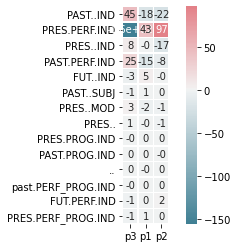

In [89]:
engdat.vpers.show()